# CONNECT TO DRIVE

In [1]:
#YOU MUST IMPORT IN YOUR DRIVE "Dataset" and "NN_Archtop" DIRECTORIES!!!

from google.colab import drive
# Connect to Drive
drive.mount('/content/drive')

# Import dataset directory
dataset_dir = '/content/drive/My Drive/Dataset/Results'

# Define the directory for saving plots
plot_directory = '/content/drive/MyDrive/NN_Archtop/plots/'
models_directory = '/content/drive/MyDrive/NN_Archtop/models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORT LIBRARIES

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'  # Set config directory for matplotlib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings
warnings.simplefilter(action='ignore', category=Warning)        # Ignore all warnings

import numpy as np
np.random.seed(seed)  # Set seed for numpy

import logging
import random
random.seed(seed)  # Set seed for random

# Install and import TensorFlow
!pip install --upgrade tensorflow
!pip install pydot

import tensorflow as tf

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Activation

# Suppress TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tf.random.set_seed(seed)  # Set seed for TensorFlow
tf.compat.v1.set_random_seed(seed)

# Print TensorFlow and Keras versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm

from scipy.stats import entropy
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Configure seaborn
sns.set(style="whitegrid")


TensorFlow version: 2.17.0
Keras version: 3.4.1


# LOAD DATA

## Inputs

In [259]:
# Define the path to the input file
input_file = os.path.join(dataset_dir, 'inputs/csv', 'inputs.csv')

# Load the input file
inputs = pd.read_csv(input_file)  # Load the inputs from the CSV file

# Convert the data to a NumPy array if necessary
inputs_values = inputs.values
inputs_df = pd.DataFrame(inputs_values)  # Optionally create a DataFrame from the NumPy array

# Verify the shape of the input matrix
print(f'Input shape: {inputs.shape}')

# Display the first few rows of the input DataFrame for verification
inputs.head()  # Show the first few rows of the DataFrame


Input shape: (500, 7)


,rho,Ex,Ey,Ez,Gxy,Gyz,Gxz
0,350.000000,9.790000e+09,1.253120e+09,5.776100e+08,1.213960e+09,9.790000e+07,1.174800e+09
1,346.421514,9.199058e+09,1.353121e+09,6.227876e+08,9.514776e+08,9.716449e+07,1.126375e+09
2,349.760274,1.354111e+10,1.011999e+09,6.312380e+08,1.145497e+09,1.252473e+08,8.549418e+08
3,375.389148,9.635673e+09,1.477035e+09,5.480124e+08,1.176283e+09,1.343603e+08,1.588633e+09
4,375.440980,9.047328e+09,1.345184e+09,4.639244e+08,1.483579e+09,6.982546e+07,8.608727e+08


## Eigenfrequencies

In [260]:
# Function to load and prepare eigenfrequency data
def load_eigen_data(num_simulations):
    eigen_data = []  # Initialize a list to hold all eigenfrequency data columns
    labels = []  # List to hold the column labels

    for i in range(1, num_simulations + 1):
        file_path = os.path.join(eigen_dir, f'eigenFreq_sim{i}.csv')
        if os.path.isfile(file_path):
            # Load the CSV file, assuming the first row contains headers
            df = pd.read_csv(file_path, header=None)
            # Extract labels from the first row and add them to the list
            labels.extend(df.iloc[0, :].values)  # Use 'extend' to append elements to the list
            # Exclude the first row (labels) and append the data
            eigen_data.append(df.iloc[1:, :].values.flatten())

    # Combine all eigenfrequency data into one matrix
    eigen_data_combined = np.vstack(eigen_data)

    # Transpose the matrix to obtain a dimension of 40x500
    eigen_data_transposed = eigen_data_combined.T

    return eigen_data_combined, eigen_data_transposed, labels


In [261]:
# Directory where the eigenfrequency files (eigenFreq_sim#.csv) are located
eigen_dir = os.path.join(dataset_dir, 'eigenfrequencies/csv')

# Load the eigenfrequency data for the specified number of simulations
eigen_data_combined, eigen_data_transposed, labels = load_eigen_data(500)

# Create a pandas DataFrame for the eigenfrequencies, using the labels as column headers
eigen_df = pd.DataFrame(eigen_data_transposed, columns=labels)

# Print the transposed eigenfrequency matrix as a table
print("Eigenfrequency matrix (40x500) as a table:")
print(eigen_df.head())

# `eigen_data_combined` is now available for further usage
print(f"Original combined eigenfrequency matrix (500x40): {eigen_data_combined.shape}")


Eigenfrequency matrix (40x500) as a table:
      Freq(Hz)_sim1     Freq(Hz)_sim2     Freq(Hz)_sim3     Freq(Hz)_sim4  \
0  184.310518191334  183.580064116524  185.878772904251  184.599238269921   
1   306.92971673929   304.05714003402  313.427436258425  305.633529317367   
2  359.849984762488  352.531679061279  364.306310525442  362.107566618621   
3  378.724807269378  378.174944589162  379.804769863096  378.912901641641   
4  397.141117692521  395.491914739349  398.735578662997  399.104645045212   

      Freq(Hz)_sim5     Freq(Hz)_sim6     Freq(Hz)_sim7     Freq(Hz)_sim8  \
0  182.760196839902   183.58006411648   185.87877290422    187.6353106063   
1  299.084866628265  304.057140032389  313.427436258338  325.077415651546   
2  348.353338611603  352.531679061054   364.30631051886  381.439506006358   
3  377.246782485132  378.174944588652  379.804769873878  382.420267667382   
4  391.640243123641  395.491914746233  398.735578665593  408.720173900351   

      Freq(Hz)_sim9    Freq(Hz)

In [262]:
# Create a DataFrame to combine the inputs and eigenfrequencies
df_InpEig = pd.DataFrame(
    np.hstack([inputs_df.values, eigen_data_combined]),
    columns=list(inputs.columns) + [f'EigenFreq_{i+1}' for i in range(eigen_data_combined.shape[1])]
)

# Print the first few rows of the combined DataFrame
print("First rows of the combined DataFrame:")
df_InpEig.head()


First rows of the combined DataFrame:


,rho,Ex,Ey,Ez,Gxy,Gyz,Gxz,EigenFreq_1,EigenFreq_2,EigenFreq_3,...,EigenFreq_31,EigenFreq_32,EigenFreq_33,EigenFreq_34,EigenFreq_35,EigenFreq_36,EigenFreq_37,EigenFreq_38,EigenFreq_39,EigenFreq_40
0,350.0,9790000000.0,1253120000.0,577610000.0,1213960000.0,97900000.0,1174800000.0,184.310518191334,306.92971673929,359.849984762488,...,1001.89531633456,1007.2773625795,1014.68430341783,1049.79103009534,1079.82568154531,1086.0509797587,1100.3150533213,1120.37137199806,1135.77884148552,1161.7424649599
1,346.421514,9199058365.665991,1353121087.24577,622787563.500936,951477593.891201,97164494.525596,1126375032.05831,183.580064116524,304.05714003402,352.531679061279,...,1001.93832795582,1004.17499289141,1005.45495606291,1040.94208020281,1068.66367992862,1086.23082911049,1100.37840297894,1119.50029602361,1128.82304904954,1133.62620879304
2,349.760274,13541112679.526899,1011999062.53925,631238029.009584,1145497389.7547,125247291.497484,854941816.543158,185.878772904251,313.427436258425,364.306310525442,...,1001.78071162265,1008.90477521054,1020.95709429509,1053.72894030571,1085.72561631184,1088.70719706084,1100.21101954238,1120.08102829053,1138.13264860034,1168.91107063757
3,375.389148,9635673197.86832,1477034656.91064,548012388.766367,1176283431.75983,134360348.950549,1588633429.6544,184.599238269921,305.633529317367,362.107566618621,...,1001.91275973037,1010.3850931668,1014.02151719865,1056.3935057353,1079.60753962484,1085.8509760246,1100.27474236283,1121.03817684628,1141.98825933438,1161.51391686811
4,375.44098,9047328336.586229,1345184053.21204,463924394.930243,1483579190.28213,69825459.13193,860872746.436049,182.760196839902,299.084866628265,348.353338611603,...,995.027485846135,1001.9868020307,1007.75521780738,1023.87930561386,1060.74491968784,1086.32178662024,1100.36767841117,1107.92480977911,1118.32236896629,1141.06196293321


## SPL

In [263]:
# Function to load and prepare data for a specific simulation
def load_simulation_data(sim_number, is_fibonacci=True):
    if is_fibonacci:
        spl_file = os.path.join(spl_fibonacci_dir, f'ampsFib_sim{sim_number}.csv')
    else:
        spl_file = os.path.join(spl_meridians_dir, f'ampsMer_sim{sim_number}.csv')

    # Load SPL data
    spl_data = pd.read_csv(spl_file, header=None, skiprows=1).values

    # Load eigenfrequency data
    eigen_file = os.path.join(eigen_dir, f'eigenFreq_sim{sim_number}.csv')
    eigen_data = pd.read_csv(eigen_file, header=None).values.flatten()

    # Sort eigenfrequencies and round to two decimal places, ignoring the first value
    eigen_sorted = np.round(np.sort(eigen_data[1:].astype(float)), 2)

    return spl_data, eigen_sorted

# Function to accumulate SPL data into a matrix
def create_matrix_from_csv(directory, num_simulations, is_fibonacci=True):
    # Load the first simulation to get the shape of the data
    sample_data, _ = load_simulation_data(1, is_fibonacci)
    num_rows, num_cols = sample_data.shape

    # Create an empty matrix to store SPL data
    matrix = np.empty((num_simulations, num_rows, num_cols))

    # Loop over each simulation to load and store its data
    for sim_number in range(1, num_simulations + 1):
        spl_data, _ = load_simulation_data(sim_number, is_fibonacci)
        matrix[sim_number - 1, :, :] = spl_data

    return matrix

# Function to save the matrix to a file
def save_matrix_to_file(matrix, filename):
    np.save(filename, matrix)

# Function to load the matrix from a file
def load_matrix_from_file(filename):
    return np.load(filename)

# Function to remove the first and last points (North Pole and South Pole) from each matrix
def remove_poles(matrix):
    # Remove the first and last rows from each simulation matrix
    return matrix[:, :, 1:-1]

In [264]:
# Directories for SPL and eigenfrequencies
spl_fibonacci_dir = os.path.join(dataset_dir, 'SPL(dB)/Fibonacci/csv')
spl_meridians_dir = os.path.join(dataset_dir, 'SPL(dB)/Meridians/csv')
eigen_dir = os.path.join(dataset_dir, 'eigenfrequencies/csv')

# Number of simulations to test
test_num_simulations = 500

# Filenames for saving the matrices
fibonacci_matrix_file = 'fibonacci_matrix.npy'
meridians_matrix_file = 'meridians_matrix.npy'

# Check if the matrices already exist, otherwise load and save them
if os.path.exists(fibonacci_matrix_file):
    fibonacci_matrix = load_matrix_from_file(fibonacci_matrix_file)
else:
    fibonacci_matrix = create_matrix_from_csv(spl_fibonacci_dir, test_num_simulations, is_fibonacci=True)
    save_matrix_to_file(fibonacci_matrix, fibonacci_matrix_file)

if os.path.exists(meridians_matrix_file):
    meridians_matrix = load_matrix_from_file(meridians_matrix_file)
else:
    meridians_matrix = create_matrix_from_csv(spl_meridians_dir, test_num_simulations, is_fibonacci=False)
    save_matrix_to_file(meridians_matrix, meridians_matrix_file)

# Verify the shape of the matrices
print(f'Fibonacci Matrix Shape: {fibonacci_matrix.shape}')

# Remove the first and last points from the Meridians matrices
meridians_matrix = remove_poles(meridians_matrix)
print(f'Meridians Matrix Shape: {meridians_matrix.shape}')



Fibonacci Matrix Shape: (500, 40, 60)
Meridians Matrix Shape: (500, 40, 60)


##Plots

### SPL Entropy

In [9]:
# Function to calculate Shannon entropy for a matrix using MinMaxScaler
def calculate_entropy_with_scaler(matrix):
    scaler = MinMaxScaler(feature_range=(0, 1))  # Create a scaler to normalize data between 0 and 1
    entropies = []

    for sim in range(matrix.shape[0]):
        # Flatten the matrix for each simulation
        flattened_data = matrix[sim, :, :].flatten()

        # Reshape for the scaler since MinMaxScaler requires a 2D array
        flattened_data = flattened_data.reshape(-1, 1)

        # Normalize the data between 0 and 1
        scaled_data = scaler.fit_transform(flattened_data).flatten()

        # Further normalization to make it a probability distribution
        if scaled_data.size > 0:
            normalized_data = scaled_data / np.sum(scaled_data)  # Turn data into a probability distribution
            entropies.append(entropy(normalized_data))  # Calculate Shannon entropy
        else:
            entropies.append(0)  # Append 0 if data contains no valid values

    return entropies

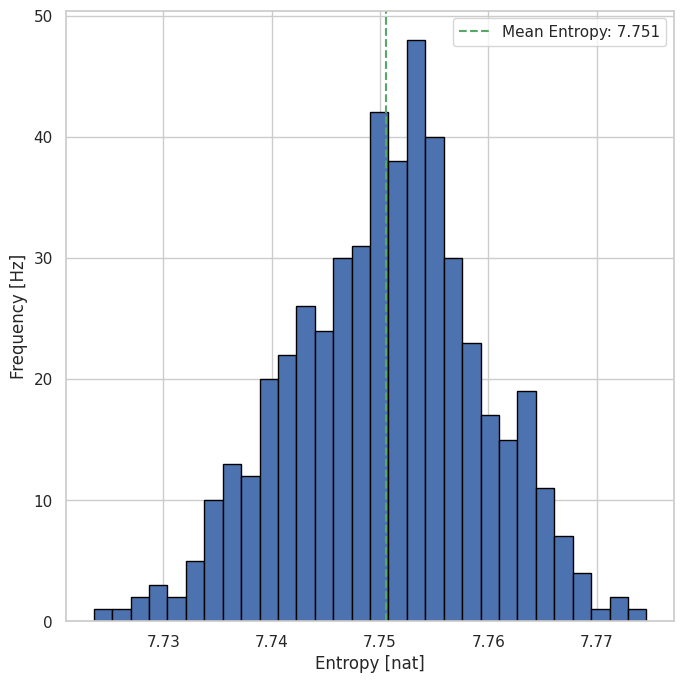

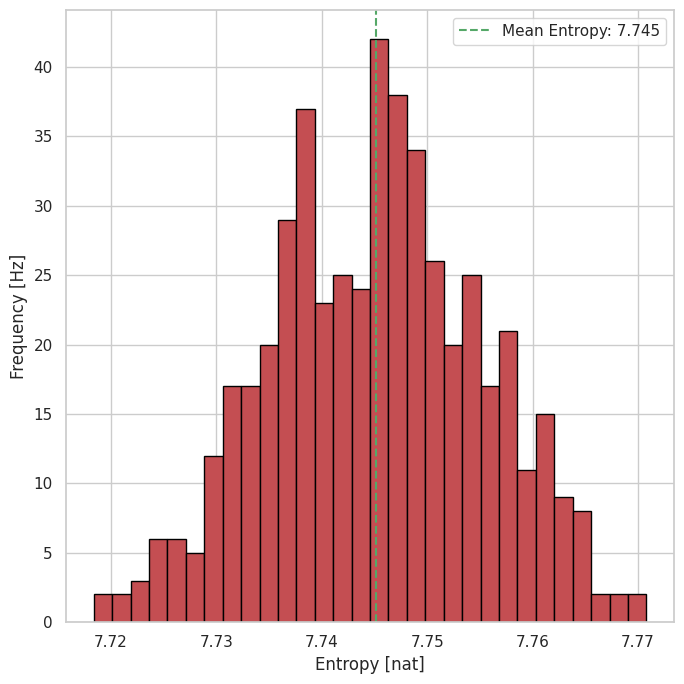

In [10]:
# Calculate entropy for each simulation using the scaler
fibonacci_entropies = calculate_entropy_with_scaler(fibonacci_matrix)
meridians_entropies = calculate_entropy_with_scaler(meridians_matrix)

# Calculate mean entropy
mean_fibonacci_entropy = np.mean(fibonacci_entropies)
mean_meridians_entropy = np.mean(meridians_entropies)

# Histogram of entropy for Fibonacci
plt.figure(figsize=(7, 7))
plt.hist(fibonacci_entropies, bins=30, color='b', edgecolor='black')
plt.axvline(mean_fibonacci_entropy, color='g', linestyle='--', label=f'Mean Entropy: {mean_fibonacci_entropy:.3f}')
# plt.title('Entropy Distribution - Fibonacci')
plt.xlabel('Entropy [nat]')
plt.ylabel('Frequency [Hz]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'entropy_fibonacci.png'), dpi=300)  # Save the Fibonacci histogram

# Histogram of entropy for Meridians
plt.figure(figsize=(7, 7))
plt.hist(meridians_entropies, bins=30, color='r', edgecolor='black')
plt.axvline(mean_meridians_entropy, color='g', linestyle='--', label=f'Mean Entropy: {mean_meridians_entropy:.3f}')
# plt.title('Entropy Distribution - Meridians')
plt.xlabel('Entropy [nat]')
plt.ylabel('Frequency [Hz]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'entropy_meridians.png'), dpi=300)  # Save the Meridians histogram


###SPL MatrixPlots

In [11]:
# Function to load and prepare data for a simulation
def load_simulation_data(sim_number, dataset_type='Fibonacci'):
    if dataset_type == 'Fibonacci':
        spl_file = os.path.join(spl_fibonacci_dir, f'ampsFib_sim{sim_number}.csv')
    elif dataset_type == 'Meridians':
        spl_file = os.path.join(spl_meridians_dir, f'ampsMer_sim{sim_number}.csv')

    # Load SPL data from the CSV file
    spl_data = pd.read_csv(spl_file, header=None, skiprows=1)

    # Load eigenfrequency data from the corresponding CSV file
    eigen_file = os.path.join(eigen_dir, f'eigenFreq_sim{sim_number}.csv')
    eigen_data = pd.read_csv(eigen_file, header=None)

    # Sort eigenfrequencies and round to two decimal places
    eigen_sorted = np.round(np.sort(eigen_data.iloc[1:, 0].values.astype(float)), 2)

    return spl_data, eigen_sorted

# Function to create a matrix plot for each simulation
def plot_matrix(spl_data, eigen_sorted, ax, title):
    # Generate a heatmap using the SPL data
    sns.heatmap(spl_data.astype(float), cmap='bwr', linewidths=0.5, linecolor='black', ax=ax, cbar=False,
                xticklabels=False, yticklabels=False)  # Ignore labels for better visualization
    ax.set_title(title, fontsize=8)

# Function to create subplots for multiple simulations
def create_subplots(num_simulations, dataset_type='Fibonacci', save_path=None):
    # Calculate rows and columns for the grid of subplots
    cols = 5
    rows = math.ceil(num_simulations / cols)

    # Set up the figure size based on the number of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 4), constrained_layout=True)

    # Handle cases where fewer simulations are present than the number of cells
    if num_simulations <= cols:
        axs = axs.reshape(-1)  # Make axs one-dimensional if there's only one row
    else:
        axs = axs.flatten()  # Flatten axs to a one-dimensional array

    # Loop through each simulation and plot its data
    for i in range(num_simulations):
        sim_number = i + 1
        spl_data, eigen_sorted = load_simulation_data(sim_number, dataset_type)
        plot_matrix(spl_data, eigen_sorted, axs[i], f'Sim {sim_number}')

    # Hide any unused axes in the plot grid
    for j in range(num_simulations, len(axs)):
        fig.delaxes(axs[j])

    # If save_path is provided, save the plot as a file
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the figure
        print(f"Plot saved at {save_path}")

    plt.show()


In [12]:
plotMatrixes=False # set to true if you want to run the next part of the code and plot the MATRIXPLOTS (it will require a LOT of time remember that)!

#### Fibonacci

In [13]:
# Example call for creating matrix plots for Fibonacci simulations and saving the plot
print('Fibonacci Matrixplots')
print('---------------------------------')
if plotMatrixes:
  create_subplots(75, dataset_type='Fibonacci', save_path=os.path.join(plot_directory,'fibonacci_matrixplots.png'))


Fibonacci Matrixplots
---------------------------------


#### Meridians

In [14]:
# Esempio di chiamata per le simulazioni di Meridians
print('\nMeridians Matrixplots')
print('---------------------------------')
# create_subplots(75, dataset_type='Meridians')
if plotMatrixes:
  create_subplots(75, dataset_type='Meridians', save_path=os.path.join(plot_directory,'meridians_matrixplots.png'))



Meridians Matrixplots
---------------------------------


# NEURAL NETWORKS

###Set Framework

#### Training, Validation, Test

In [265]:
#For FFNN

# Split the data while maintaining correspondence between inputs and eigenfrequencies
train_df, test_df = train_test_split(df_InpEig, test_size=0.1, random_state=seed)

# Further split the training set to obtain the validation set (20% of the training set)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=seed)  # 20% of the training set as validation

# Separate the inputs and eigenfrequencies in the training, validation, and test sets
inputs_train = train_df[list(inputs.columns)].values
eigenTarget_train = train_df[[f'EigenFreq_{i+1}' for i in range(eigen_data_combined.shape[1])]].values

inputs_val = val_df[list(inputs.columns)].values
eigenTarget_val = val_df[[f'EigenFreq_{i+1}' for i in range(eigen_data_combined.shape[1])]].values

inputs_test = test_df[list(inputs.columns)].values
eigenTarget_test = test_df[[f'EigenFreq_{i+1}' for i in range(eigen_data_combined.shape[1])]].values

# Verify the dimensions
print('Training set shape (Inputs, EigenTarget):\t', inputs_train.shape, eigenTarget_train.shape)
print('Validation set shape (Inputs, EigenTarget):\t', inputs_val.shape, eigenTarget_val.shape)
print('Test set shape (Inputs, EigenTarget):\t\t', inputs_test.shape, eigenTarget_test.shape)

Training set shape (Inputs, EigenTarget):	 (360, 7) (360, 40)
Validation set shape (Inputs, EigenTarget):	 (90, 7) (90, 40)
Test set shape (Inputs, EigenTarget):		 (50, 7) (50, 40)


In [266]:
#For CONV NN

# Define SPL matrices
fibonacci_spl = fibonacci_matrix
meridians_spl = meridians_matrix

# Split 90% for training and 10% for testing
train_idx, test_idx = train_test_split(np.arange(len(eigen_data_combined)), test_size=0.1, random_state=seed)
# Further split the training set to obtain the validation set (20% of the training set)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=seed)

# Now, split the eigenfrequencies and SPL data based on the obtained indices
eigen_train = eigen_data_combined[train_idx]
eigen_val = eigen_data_combined[val_idx]
eigen_test = eigen_data_combined[test_idx]

fibonacci_train = fibonacci_spl[train_idx]
fibonacci_val = fibonacci_spl[val_idx]
fibonacci_test = fibonacci_spl[test_idx]

meridians_train = meridians_spl[train_idx]
meridians_val = meridians_spl[val_idx]
meridians_test = meridians_spl[test_idx]

# Verify the dimensions
print("\nTrain Set Shape (Eigenfrequencies):\t\t", eigen_train.shape)
print("Validation Set Shape (Eigenfrequencies):\t", eigen_val.shape)
print("Test Set Shape (Eigenfrequencies):\t\t", eigen_test.shape)

print("\nTrain Set Shape (Fibonacci):\t\t\t", fibonacci_train.shape)
print("Validation Set Shape (Fibonacci):\t\t", fibonacci_val.shape)
print("Test Set Shape (Fibonacci):\t\t\t", fibonacci_test.shape)

print("\nTrain Set Shape (Meridians):\t\t\t", meridians_train.shape)
print("Validation Set Shape (Meridians):\t\t", meridians_val.shape)
print("Test Set Shape (Meridians):\t\t\t", meridians_test.shape)


Train Set Shape (Eigenfrequencies):		 (360, 40)
Validation Set Shape (Eigenfrequencies):	 (90, 40)
Test Set Shape (Eigenfrequencies):		 (50, 40)

Train Set Shape (Fibonacci):			 (360, 40, 60)
Validation Set Shape (Fibonacci):		 (90, 40, 60)
Test Set Shape (Fibonacci):			 (50, 40, 60)

Train Set Shape (Meridians):			 (360, 40, 60)
Validation Set Shape (Meridians):		 (90, 40, 60)
Test Set Shape (Meridians):			 (50, 40, 60)


#### Batch & Epochs

In [267]:
# Define the batch size, which is the number of samples processed in each training iteration
batch_size = 64

# Define the number of training epochs,
# which is the number of times the entire dataset is passed through the network during training
epochs = 1000

####Convert to Float32

In [268]:
# Convert eigen data to float32 if it's not already
eigen_data_combined = eigen_data_combined.astype(np.float32)

# Ensure eigenfrequencies and Fibonacci data are in float32 format
eigen_train = eigen_train.astype(np.float32) if eigen_train.dtype != np.float32 else eigen_train
fibonacci_train = fibonacci_train.astype(np.float32) if fibonacci_train.dtype != np.float32 else fibonacci_train
eigen_val = eigen_val.astype(np.float32) if eigen_val.dtype != np.float32 else eigen_val
fibonacci_val = fibonacci_val.astype(np.float32) if fibonacci_val.dtype != np.float32 else fibonacci_val
eigen_test = eigen_test.astype(np.float32) if eigen_test.dtype != np.float32 else eigen_test
fibonacci_test = fibonacci_test.astype(np.float32) if fibonacci_test.dtype != np.float32 else fibonacci_test

# Convert input data to float32
inputs_train = inputs_train.astype(np.float32)
eigenTarget_train = eigenTarget_train.astype(np.float32)
inputs_val = inputs_val.astype(np.float32)
eigenTarget_val = eigenTarget_val.astype(np.float32)

# Note: The code above will modify the original variables to float32 format.


## FFNN

###Normalization

In [19]:
# Data normalization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform on the training data
inputs_train_scaled = scaler_X.fit_transform(inputs_train)
eigenTarget_train_scaled = scaler_y.fit_transform(eigenTarget_train)

# Transform the validation and test data
inputs_val_scaled = scaler_X.transform(inputs_val)
eigenTarget_val_scaled = scaler_y.transform(eigenTarget_val)
inputs_test_scaled = scaler_X.transform(inputs_test)
eigenTarget_test_scaled = scaler_y.transform(eigenTarget_test)

# Check for NaN or inf in scaled test data
print("Check for NaN or inf in inputs_test_scaled:", np.any(np.isnan(inputs_test_scaled)) or np.any(np.isinf(inputs_test_scaled)))
print("Check for NaN or inf in eigenTarget_test_scaled:", np.any(np.isnan(eigenTarget_test_scaled)) or np.any(np.isinf(eigenTarget_test_scaled)))


Check for NaN or inf in inputs_test_scaled: False
Check for NaN or inf in eigenTarget_test_scaled: False


###Model

####Keras

In [20]:
# Build a simple neural network model with named layers
inputs = tfkl.Input(shape=(7,), name='input_layer')
dense_layer_1 = tfkl.Dense(40, use_bias=False, kernel_initializer='glorot_uniform', name='dense_layer_1')(inputs) # First Dense layer
outputs = tfkl.Dense(eigenTarget_train.shape[1], name='output_layer')(dense_layer_1) # Output layer

Model: "FFNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 40)                  │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 40)                  │           1,640 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,920 (7.50 KB)

 Trainable params: 1,920 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

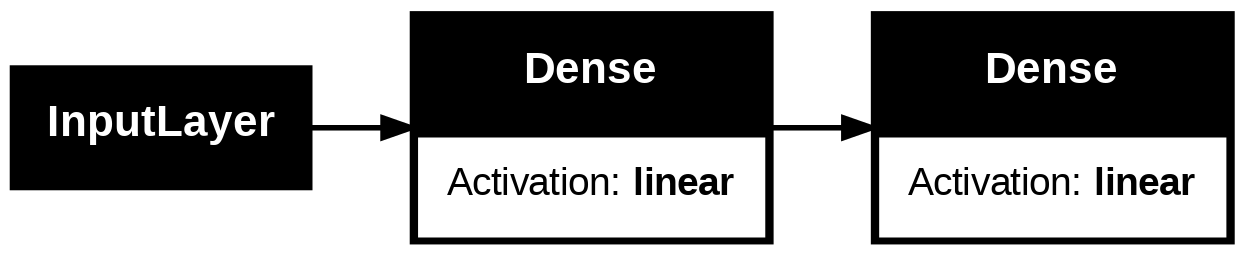

In [21]:
# Create the model
model = tfk.Model(inputs=inputs, outputs=outputs, name='FFNN_model')

# Compile the model
optimizer = tfk.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Show the model summary
model.summary()

# Plot the model, displaying input/output shapes
tfk.utils.plot_model(model, show_shapes=False, show_layer_names=False, rankdir='LR', show_layer_activations=True)

####Upload Model

In [22]:
# Path for the weights file
FFNN_weights_path = os.path.join(models_directory,'FFNN_weights.weights.h5')

# Check if the weights file exists
if os.path.exists(FFNN_weights_path):
    # Load the weights for the Meridians dataset
    model.load_weights(FFNN_weights_path)  # Load previously saved weights for Meridians
    print("Weights loaded successfully. Skipping training.")
else:
    print("Weights file not found. Proceed with training.")


Weights loaded successfully. Skipping training.


####Train, Save Model

In [23]:
# Set this to True if you want to force training if the val loss & MAE does not work!
force_training = False

# Check if the weights file exists
if not os.path.exists(FFNN_weights_path) or force_training:
    # Early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # Train the model and capture the history object
    history = model.fit(
        x=inputs_train_scaled,
        y=eigenTarget_train_scaled,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(inputs_val_scaled, eigenTarget_val_scaled),
        callbacks=[early_stopping],
        verbose=0
    )

    # Save the model weights with the correct extension
    model.save_weights(FFNN_weights_path)
    print("Weights saved successfully.")
else:
    print("Weights already exist. Skipping training and saving.")


Weights already exist. Skipping training and saving.


####Predictions

In [24]:
# Make predictions using the trained model
predictions_nn = model.predict(inputs_test_scaled)
# Check the shape of the predictions
print("Shape of predictions:\t\t", predictions_nn.shape)  # Should be (n_sim, 40, 60)

# Inverse normalization of the predictions
eigen_pred = scaler_y.inverse_transform(predictions_nn)
# Check the shape of the descaled predictions
print("Shape of descaled predictions:\t", eigen_pred.shape)  # Should be (n_sim, 40, 60)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Shape of predictions:		 (50, 40)
Shape of descaled predictions:	 (50, 40)


### Plots


####Val Loss & MAE

In [25]:
# Check if the history variable exists (i.e., training was done)
if 'history' in locals():
    # Set figure size
    plt.figure(figsize=(7, 7))

    # Plot Loss Curve
    plt.subplot(1, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, 'FFNN_loss_curve.png'))  # Save the loss curve
    plt.show()

    # Plot MAE Curve
    plt.figure(figsize=(7, 7))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, 'FFNN_mae_curve.png'))  # Save the MAE curve
    plt.show()

    # Display final values
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
    print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")
else:
    print("No training history found. Please train the model in 'Train,Save Model' box of FFNN to visualize metrics.")


No training history found. Please train the model in 'Train,Save Model' box of FFNN to visualize metrics.


#### Scatter Plot

Shape of X_test: (50, 7)
Shape of y_test: (50, 40)
Shape of y_pred: (50, 40)
Range of actual values (y_test): min=177.88, max=1199.45
Range of predicted values (y_pred): min=179.34, max=1185.0



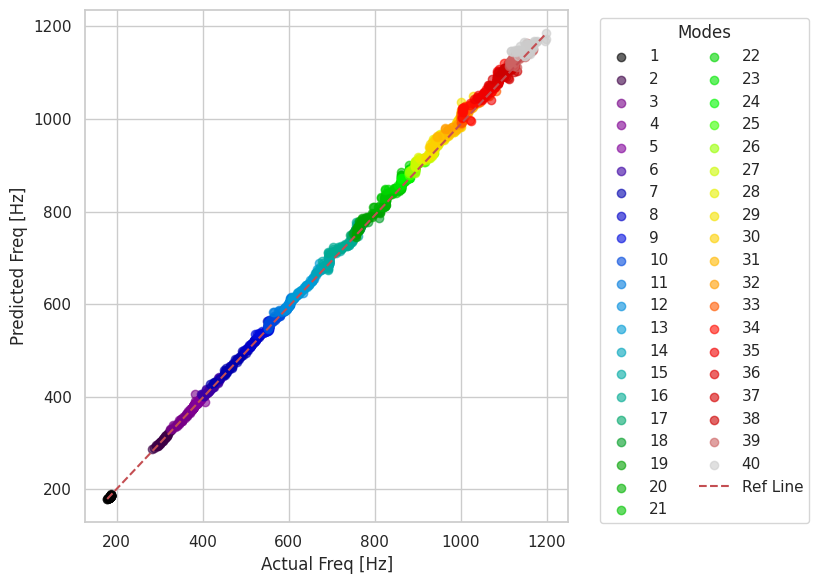

In [26]:
# Assume num_modes is the number of modes in the dataset
num_modes = 40  # Set the number of modes (update this value based on your data)

# Check the shape of the data
print(f'Shape of X_test: {inputs_test_scaled.shape}')
print(f'Shape of y_test: {eigenTarget_test.shape}')
print(f'Shape of y_pred: {eigen_pred.shape}')

# Convert y_test and y_pred to float64 type
eigenTarget_test = eigenTarget_test.astype(np.float64)
eigen_pred = eigen_pred.astype(np.float64)

# Assuming y_test and y_pred have a shape of (n_samples, num_modes)
# If not, flatten the data
eigenTarget_test_rounded = np.round(eigenTarget_test, 2)
eigen_pred_rounded = np.round(eigen_pred, 2)

# Print the ranges of the rounded values
print(f'Range of actual values (y_test): min={np.min(eigenTarget_test_rounded)}, max={np.max(eigenTarget_test_rounded)}')
print(f'Range of predicted values (y_pred): min={np.min(eigen_pred_rounded)}, max={np.max(eigen_pred_rounded)}\n')

# Create scatter plot with different colors for each mode
plt.figure(figsize=(10, 6))

# Use a colormap to assign distinct colors for each mode
colors = plt.cm.get_cmap('nipy_spectral', num_modes)

# Loop over each mode to create distinctly colored scatter plots
for mode in range(num_modes):
    plt.scatter(
        eigenTarget_test_rounded[:, mode],
        eigen_pred_rounded[:, mode],
        alpha=0.6,
        color=colors(mode),
        label=f'{mode + 1}'  # Label for the legend
    )

# Add a reference line
plt.plot(
    [min(eigenTarget_test_rounded.flatten()), max(eigenTarget_test_rounded.flatten())],
    [min(eigen_pred_rounded.flatten()), max(eigen_pred_rounded.flatten())],
    'r--', label='Ref Line'
)

# Add labels and title
plt.xlabel('Actual Freq [Hz]')
plt.ylabel('Predicted Freq [Hz]')
# plt.title('Comparison between Actual and Predicted Frequencies')

# Add legend outside the plot
plt.legend(title="Modes", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 'ncol=2' creates 2 columns for the legend

# Improve spacing and overall appearance
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space on the right for the legend

# Add grid
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(plot_directory,'FFNN_scatterPlot.png'), bbox_inches='tight')

# Show the plot
plt.show()

#### Average Error per Mode

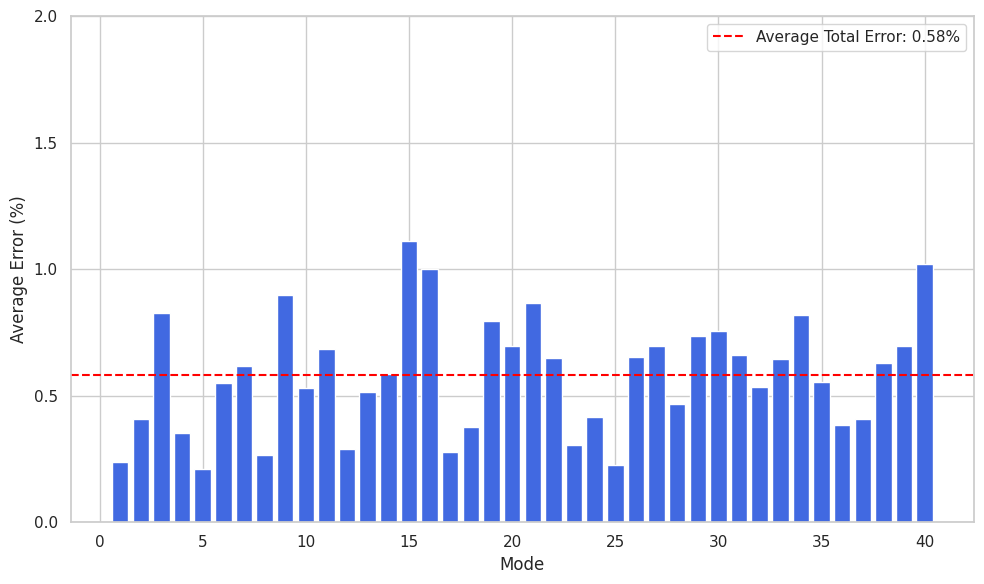

In [27]:
# Calculate the absolute error for each mode
errors = np.abs(eigenTarget_test_rounded - eigen_pred_rounded)

# Calculate the percentage error for each mode
# To avoid division by zero, we add a small epsilon value
epsilon = 1e-8
percentage_errors = (errors / (eigenTarget_test_rounded + epsilon)) * 100

# Calculate the average percentage error for each mode
average_percentage_errors_per_mode = np.mean(percentage_errors, axis=0)

# Calculate the overall average percentage error
average_percentage_error_total = np.mean(average_percentage_errors_per_mode)

# Plot: Average percentage error per mode as a function of mode number
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, num_modes + 1), average_percentage_errors_per_mode, color='royalblue')  # Use a single color

# Add the overall average error as a horizontal line
plt.axhline(y=average_percentage_error_total, color='red', linestyle='--', label=f'Average Total Error: {average_percentage_error_total:.2f}%')

# Add labels for each bar
# for i, value in enumerate(average_percentage_errors_per_mode):
#     plt.text(i + 1, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=6)  # Set font size

plt.xlabel('Mode')
plt.ylabel('Average Error (%)')
# plt.title('Average Error per Mode')
plt.ylim(0, 2)  # Set the y-axis scale from 0 to 2%

plt.grid(True)
# Set y-axis ticks to show only integer values
plt.yticks(np.arange(0, 2.1, 0.5))

# Add legend
plt.legend()

# Save the plot
plt.savefig(os.path.join(plot_directory,'FFNN_averageError_plot.png'), bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


##CONV

###Pre-processing

#####Normalization

In [269]:
# Normalization using StandardScaler
scaler_eigen = StandardScaler()
scaler_fibonacci = StandardScaler()
scaler_meridians = StandardScaler()

# Fit and transform eigenfrequencies
eigen_train_scaled = scaler_eigen.fit_transform(eigen_train)
eigen_val_scaled = scaler_eigen.transform(eigen_val)
eigen_test_scaled = scaler_eigen.transform(eigen_test)

# Normalize SPL data (Fibonacci)
fibonacci_train_flat = fibonacci_train.reshape(-1, fibonacci_train.shape[-1])  # Flatten to normalize
fibonacci_train_scaled = scaler_fibonacci.fit_transform(fibonacci_train_flat)
fibonacci_train_scaled = fibonacci_train_scaled.reshape(fibonacci_train.shape)  # Restore original shape

fibonacci_val_flat = fibonacci_val.reshape(-1, fibonacci_val.shape[-1])
fibonacci_val_scaled = scaler_fibonacci.transform(fibonacci_val_flat)
fibonacci_val_scaled = fibonacci_val_scaled.reshape(fibonacci_val.shape)

fibonacci_test_flat = fibonacci_test.reshape(-1, fibonacci_test.shape[-1])
fibonacci_test_scaled = scaler_fibonacci.transform(fibonacci_test_flat)
fibonacci_test_scaled = fibonacci_test_scaled.reshape(fibonacci_test.shape)

# Normalize SPL data (Meridians)
meridians_train_flat = meridians_train.reshape(-1, meridians_train.shape[-1])  # Flatten to normalize
meridians_train_scaled = scaler_meridians.fit_transform(meridians_train_flat)
meridians_train_scaled = meridians_train_scaled.reshape(meridians_train.shape)  # Restore original shape

meridians_val_flat = meridians_val.reshape(-1, meridians_val.shape[-1])
meridians_val_scaled = scaler_meridians.transform(meridians_val_flat)
meridians_val_scaled = meridians_val_scaled.reshape(meridians_val.shape)

meridians_test_flat = meridians_test.reshape(-1, meridians_test.shape[-1])
meridians_test_scaled = scaler_meridians.transform(meridians_test_flat)
meridians_test_scaled = meridians_test_scaled.reshape(meridians_test.shape)

# Check dimensions
print("\nTrain Set Shape (Eigenfrequencies):\t", eigen_train_scaled.shape)
print("Validation Set Shape (Eigenfrequencies):", eigen_val_scaled.shape)
print("Test Set Shape (Eigenfrequencies):\t", eigen_test_scaled.shape)

print("\nTrain Set Shape (Fibonacci):\t\t", fibonacci_train_scaled.shape)
print("Validation Set Shape (Fibonacci):\t", fibonacci_val_scaled.shape)
print("Test Set Shape (Fibonacci):\t\t", fibonacci_test_scaled.shape)

print("\nTrain Set Shape (Meridians):\t\t", meridians_train_scaled.shape)
print("Validation Set Shape (Meridians):\t", meridians_val_scaled.shape)
print("Test Set Shape (Meridians):\t\t", meridians_test_scaled.shape)



Train Set Shape (Eigenfrequencies):	 (360, 40)
Validation Set Shape (Eigenfrequencies): (90, 40)
Test Set Shape (Eigenfrequencies):	 (50, 40)

Train Set Shape (Fibonacci):		 (360, 40, 60)
Validation Set Shape (Fibonacci):	 (90, 40, 60)
Test Set Shape (Fibonacci):		 (50, 40, 60)

Train Set Shape (Meridians):		 (360, 40, 60)
Validation Set Shape (Meridians):	 (90, 40, 60)
Test Set Shape (Meridians):		 (50, 40, 60)


####Augmentation

In [270]:
def add_noise(data, noise_level=0.01):
    """
    Adds Gaussian noise to the input data.

    Parameters:
    - data: Input array to which noise will be added.
    - noise_level: Scale of the noise as a fraction of the data's standard deviation (default: 0.01).

    Returns:
    - data with added Gaussian noise.
    """
    noise = np.random.normal(0, noise_level * np.std(data), data.shape)  # Generate Gaussian noise
    return data + noise  # Add the noise to the original data

def perturb_data(data, perturbation_factor_range=(0.95, 1.05)):
    """
    Applies a random perturbation (scaling) to the input data.

    Parameters:
    - data: Input array to be perturbed.
    - perturbation_factor_range: Range within which the perturbation factor will be randomly selected (default: between -5% and +5%).

    Returns:
    - data scaled by the random perturbation factor.
    """
    factor = np.random.uniform(perturbation_factor_range[0], perturbation_factor_range[1])  # Random scaling factor
    return data * factor  # Scale the data by the random factor


In [271]:
# Augmentation for the training dataset
augmented_train_eigenfrequencies = add_noise(eigen_train_scaled)
augmented_train_fibonacci = add_noise(fibonacci_train_scaled)
augmented_train_meridians = add_noise(meridians_train_scaled)

# Apply perturbation as well
augmented_train_eigenfrequencies = perturb_data(augmented_train_eigenfrequencies)
augmented_train_fibonacci = perturb_data(augmented_train_fibonacci)
augmented_train_meridians = perturb_data(augmented_train_meridians)

# Create a new training dataset by combining original and augmented data
combined_train_eigenfrequencies = np.concatenate((eigen_train_scaled, augmented_train_eigenfrequencies), axis=0)
combined_train_fibonacci = np.concatenate((fibonacci_train_scaled, augmented_train_fibonacci), axis=0)
combined_train_meridians = np.concatenate((meridians_train_scaled, augmented_train_meridians), axis=0)

# Update the training sets with combined data
eigen_train_scaled = combined_train_eigenfrequencies
fibonacci_train_scaled = combined_train_fibonacci
meridians_train_scaled = combined_train_meridians

# Print the new shapes of the training datasets
print("New shape of Train Set (Eigenfrequencies):\t", combined_train_eigenfrequencies.shape)
print("New shape of Train Set (Fibonacci):\t\t", combined_train_fibonacci.shape)
print("New shape of Train Set (Meridians):\t\t", combined_train_meridians.shape)


New shape of Train Set (Eigenfrequencies):	 (720, 40)
New shape of Train Set (Fibonacci):		 (720, 40, 60)
New shape of Train Set (Meridians):		 (720, 40, 60)


###Model

#### Keras

In [272]:
# Expanding the dimensions for Conv2D input
# Reshaping eigen_train, eigen_val, and eigen_test
eigen_train_expanded = eigen_train_scaled.reshape(-1, 40, 1, 1)  # (360, 40, 1, 1)
eigen_val_expanded = eigen_val_scaled.reshape(-1, 40, 1, 1)      # (90, 40, 1, 1)
eigen_test_expanded = eigen_test_scaled.reshape(-1, 40, 1, 1)    # (50, 40, 1, 1)


In [273]:
# Define a function to build the model
def build_CONV_model():
    filters = 32

    # Input layer
    input_layer = tfkl.Input(shape=(40, 1, 1), name='Input')

    # First Convolutional layer
    conv1 = tfkl.Conv2D(
        filters=filters,
        kernel_size=(7, 7),
        strides=(1, 1),
        activation='leaky_relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        name='Conv2D_1'
    )(input_layer)
    bn1 = tfkl.BatchNormalization(name='BatchNorm_1')(conv1)

    # Second Convolutional layer with Strides
    conv2 = tfkl.Conv2D(
        filters=filters*2,
        kernel_size=(5, 5),
        strides=(2, 2),
        activation='leaky_relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        name='Conv2D_2'
    )(bn1)
    bn2 = tfkl.BatchNormalization(name='BatchNorm_2')(conv2)

    # Third Convolutional layer
    conv3 = tfkl.Conv2D(
        filters=filters*4,
        kernel_size=(3, 3),
        strides=(2, 2),
        activation='leaky_relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        name='Conv2D_3'
    )(bn2)
    bn3 = tfkl.BatchNormalization(name='BatchNorm_3')(conv3)

    # Fourth Convolutional layer
    conv4 = tfkl.Conv2D(
        filters=filters*6,
        kernel_size=(2, 2),
        strides=(2, 2),
        activation='leaky_relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        name='Conv2D_4'
    )(bn3)
    bn4 = tfkl.BatchNormalization(name='BatchNorm_4')(conv4)

    # Flatten and Dense layers
    flatten = tfkl.Flatten(name='Flatten')(bn4)
    bn5 = tfkl.BatchNormalization(name='BatchNorm_5')(flatten)
    dropout1 = tfkl.Dropout(0.5, name='Dropout_1')(bn5)

    dense1 = tfkl.Dense(units=256, activation='leaky_relu', name='Dense_1')(dropout1)
    bn6 = tfkl.BatchNormalization(name='BatchNorm_6')(dense1)
    dropout2 = tfkl.Dropout(0.3, name='Dropout_2')(bn6)

    # Output Dense layer
    output_layer = tfkl.Dense(units=2400, activation='linear', name='Output_Dense')(dropout2)
    # Reshape final output
    output_reshape = tfkl.Reshape((40, 60), name='Reshape_Output')(output_layer)

    # Model definition
    model = tfk.Model(inputs=input_layer, outputs=output_reshape, name='CONV_Model')

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


In [274]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor validation loss
    patience=20,                   # Stop training if no improvement after 20 epochs
    restore_best_weights=True      # Restore model weights from the epoch with the best validation loss
)

####Fibonacci

#####Build

Model: "CONV_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 40, 1, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (None, 40, 1, 32)           │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_1 (BatchNormalization)     │ (None, 40, 1, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 20, 1, 64)           │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_2 (BatchNormalization)     │ (None, 20, 1, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 10, 1, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_3 (BatchNormalization)     │ (None, 10, 1, 128)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4 (Conv2D)                    │ (None, 5, 1, 192)           │          98,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_4 (BatchNormalization)     │ (None, 5, 1, 192)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_5 (BatchNormalization)     │ (None, 960)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_6 (BatchNormalization)     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Dense (Dense)                 │ (None, 2400)                │         616,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Reshape_Output (Reshape)             │ (None, 40, 60)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,094,560 (4.18 MB)

 Trainable params: 1,091,296 (4.16 MB)

 Non-trainable params: 3,264 (12.75 KB)

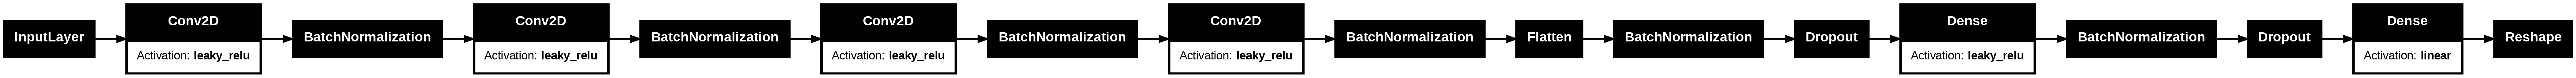

In [275]:
model_fibonacci = build_CONV_model()  # Build a fresh model
# Save the model's initial weights before any training
initial_weights_fibonacci = model_fibonacci.get_weights()

# Path for the weights file
fibonacci_weights_path = os.path.join(models_directory,'CONV_NN_Fibonacci.weights.h5')

# Model summary
model_fibonacci.summary()
tfk.utils.plot_model(model_fibonacci, show_shapes=False, show_layer_names=False, rankdir='LR', show_layer_activations=True)

#####Upload

In [162]:
# Check if the weights file exists
if os.path.exists(fibonacci_weights_path):
    # Load the weights for the Fibonacci dataset
    model_fibonacci.load_weights(fibonacci_weights_path)  # Load previously saved weights for Fibonacci
    print("Weights for Fibonacci loaded successfully. Skipping training")
    force_training = False
else:
    print("Weights file for Fibonacci not found. Proceed with training.")
    force_training = True


Weights for Fibonacci loaded successfully. Skipping training


#####Train, Save Model

In [276]:
# Set this to True if you want to force training if the val loss & MAE does not work!
# force_training = True

if force_training:
  # Restore the initial weights before training on the Fibonacci dataset
  model_fibonacci.set_weights(initial_weights_fibonacci)

  # Training on Fibonacci dataset
  history_fibonacci = model_fibonacci.fit(
      eigen_train_expanded,                                         # Training input (Eigenfrequencies)
      fibonacci_train_scaled,                                       # Training output (Fibonacci SPL)
      validation_data=(eigen_val_expanded, fibonacci_val_scaled),   # Validation input/output
      epochs=epochs,                                                # Maximum number of epochs
      batch_size=batch_size,                                        # Batch size
      verbose=0,                                                    # Suppress detailed training output
      callbacks=[early_stopping]                                    # Apply early stopping
  )
  # Save the weights after training on Fibonacci dataset
  model_fibonacci.save_weights('CONV_NN_Fibonacci.weights.h5')  # Filename for Fibonacci weights
  print("Weights for Fibonacci saved successfully.")
else:
  print("Weights for Fibonacci already exist. Skipping training.")

Weights for Fibonacci saved successfully.


#####Predictions

In [277]:
# Make predictions using the entire test set of eigenfrequencies
predictions_Fib = model_fibonacci.predict(eigen_test_expanded)  # Use your expanded test set, e.g., with shape (n_sim, 40, 1)
# Check the shape of the predictions
print("Shape of predictions (Fibonacci):\t\t", predictions_Fib.shape)  # Should be (n_sim, 40, 60)

# Descale all predictions
predictions_Fib_descaled = scaler_fibonacci.inverse_transform(predictions_Fib.reshape(-1, predictions_Fib.shape[-1])).reshape(predictions_Fib.shape)
# Check the shape of the descaled predictions
print("Shape of descaled predictions (Fibonacci):\t", predictions_Fib_descaled.shape)  # Should be (n_sim, 40, 60)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Shape of predictions (Fibonacci):		 (50, 40, 60)
Shape of descaled predictions (Fibonacci):	 (50, 40, 60)


####Meridians

#####Build

Model: "CONV_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 40, 1, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (None, 40, 1, 32)           │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_1 (BatchNormalization)     │ (None, 40, 1, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 20, 1, 64)           │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_2 (BatchNormalization)     │ (None, 20, 1, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 10, 1, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_3 (BatchNormalization)     │ (None, 10, 1, 128)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4 (Conv2D)                    │ (None, 5, 1, 192)           │          98,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_4 (BatchNormalization)     │ (None, 5, 1, 192)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_5 (BatchNormalization)     │ (None, 960)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_6 (BatchNormalization)     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Dense (Dense)                 │ (None, 2400)                │         616,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Reshape_Output (Reshape)             │ (None, 40, 60)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,094,560 (4.18 MB)

 Trainable params: 1,091,296 (4.16 MB)

 Non-trainable params: 3,264 (12.75 KB)

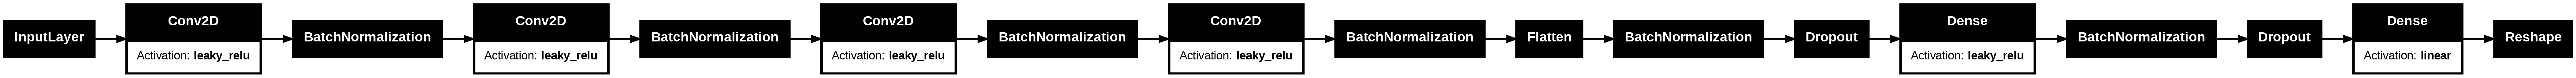

In [291]:
model_meridians = build_CONV_model()  # Build a fresh model
# Save the model's initial weights before any training
initial_weights_meridians = model_meridians.get_weights()

# Path for the weights file
meridians_weights_path = os.path.join(models_directory,'CONV_NN_Meridians.weights.h5')

# Model summary
model_meridians.summary()
tfk.utils.plot_model(model_meridians, show_shapes=False, show_layer_names=False, rankdir='LR', show_layer_activations=True)

#####Upload

In [119]:
# Check if the weights file exists
if os.path.exists(meridians_weights_path):
    # Load the weights for the Meridians dataset
    model_meridians.load_weights(meridians_weights_path)  # Load previously saved weights for Meridians
    print("Weights for Meridians loaded successfully. Skipping training.")
    force_training = False
else:
    print("Weights file for Meridians not found. Proceed with training.")
    force_training = True

Weights for Meridians loaded successfully. Skipping training.


#####Train, Save Model

In [279]:
# Set this to True if you want to force training if the val loss & MAE does not work!
# force_training = True

if force_training:
  # Restore the initial weights before training on the Meridians dataset
  model_meridians.set_weights(initial_weights_meridians)

  # Training on Meridians dataset
  history_meridians = model_meridians.fit(
      eigen_train_expanded,                                         # Training input (Eigenfrequencies)
      meridians_train_scaled,                                       # Training output (Meridians SPL)
      validation_data=(eigen_val_expanded, meridians_val_scaled),   # Validation input/output
      epochs=epochs,                                                # Maximum number of epochs
      batch_size=batch_size,                                        # Batch size
      verbose=0,                                                    # Suppress detailed training output
      callbacks=[early_stopping]                                    # Apply early stopping
  )
  # Save the weights after training on Meridians dataset
  model_meridians.save_weights('CONV_NN_Meridians.weights.h5')  # Filename for Meridians weights
  print("Weights for Meridians saved successfully.")
else:
  print("Weights for Meridians already exist. Skipping training.")

Weights for Meridians saved successfully.


#####Predictions

In [280]:
# Make predictions using the entire test set of eigenfrequencies for Meridians
predictions_Mer = model_meridians.predict(eigen_test_expanded)  # Use your expanded test set, e.g., with shape (n_sim, 40, 1)
# Check the shape of the predictions
print("Shape of predictions (Meridians):\t\t", predictions_Mer.shape)  # Should be (n_sim, 40, 60)

# Descale all predictions
predictions_Mer_descaled = scaler_meridians.inverse_transform(predictions_Mer.reshape(-1, predictions_Mer.shape[-1])).reshape(predictions_Mer.shape)
# Check the shape of the descaled predictions
print("Shape of descaled predictions (Meridians):\t", predictions_Mer_descaled.shape)  # Should be (n_sim, 40, 60)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
Shape of predictions (Meridians):		 (50, 40, 60)
Shape of descaled predictions (Meridians):	 (50, 40, 60)


###Plots

#### Validation Loss & MAE

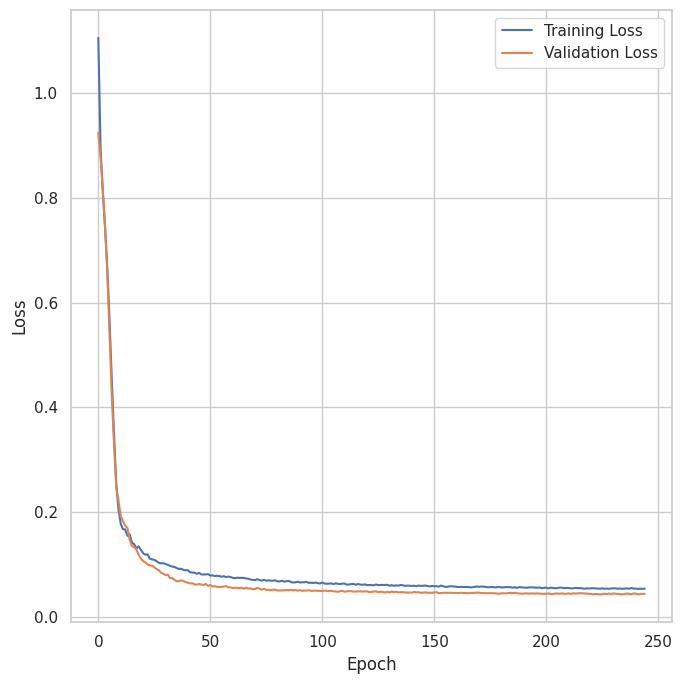

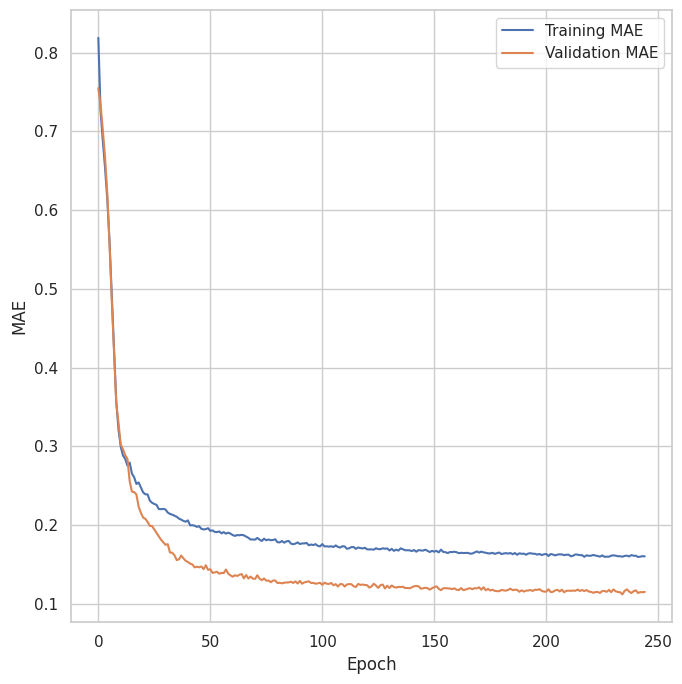

Final Training Loss (Fibonacci): 0.0546
Final Validation Loss (Fibonacci): 0.0450
Final Training MAE (Fibonacci): 0.1602
Final Validation MAE (Fibonacci): 0.1151


In [281]:
# Check if histories exist before visualizing for Fibonacci dataset
if 'history_fibonacci' in locals():
    # Visualization of training history for Fibonacci dataset
    # Loss curve for Fibonacci
    plt.figure(figsize=(7, 7))
    plt.plot(history_fibonacci.history['loss'], label='Training Loss')
    plt.plot(history_fibonacci.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.title('Fibonacci Loss Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, 'CONV_fibonacci_loss.png'), dpi=300)  # Save the loss curve
    plt.show()

    # MAE curve for Fibonacci
    plt.figure(figsize=(7, 7))
    plt.plot(history_fibonacci.history['mae'], label='Training MAE')
    plt.plot(history_fibonacci.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    # plt.title('Fibonacci MAE Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, 'CONV_fibonacci_mae.png'), dpi=300)  # Save the MAE curve
    plt.show()

    # Display final values for Fibonacci
    print(f"Final Training Loss (Fibonacci): {history_fibonacci.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss (Fibonacci): {history_fibonacci.history['val_loss'][-1]:.4f}")
    print(f"Final Training MAE (Fibonacci): {history_fibonacci.history['mae'][-1]:.4f}")
    print(f"Final Validation MAE (Fibonacci): {history_fibonacci.history['val_mae'][-1]:.4f}")
else:
    print("Fibonacci training history not found. Please train the model in 'Train,Save Model' box of Fibonacci to visualize metrics.")

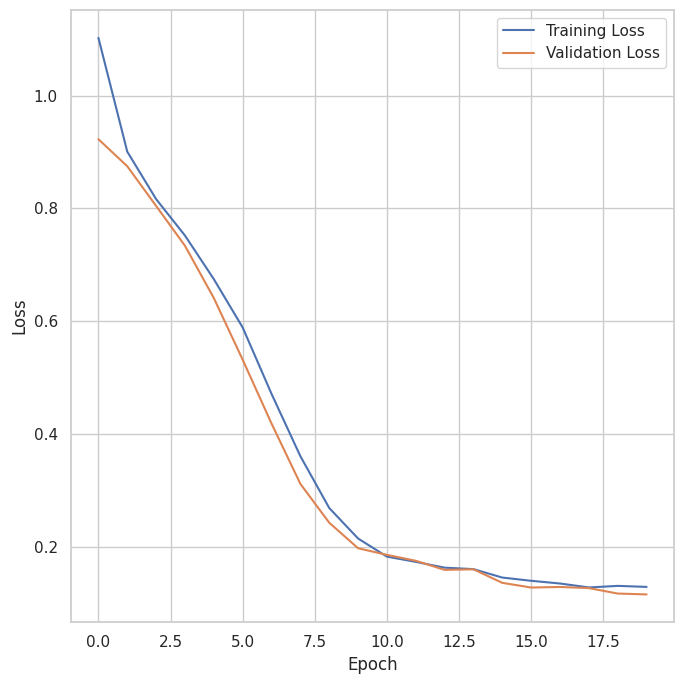

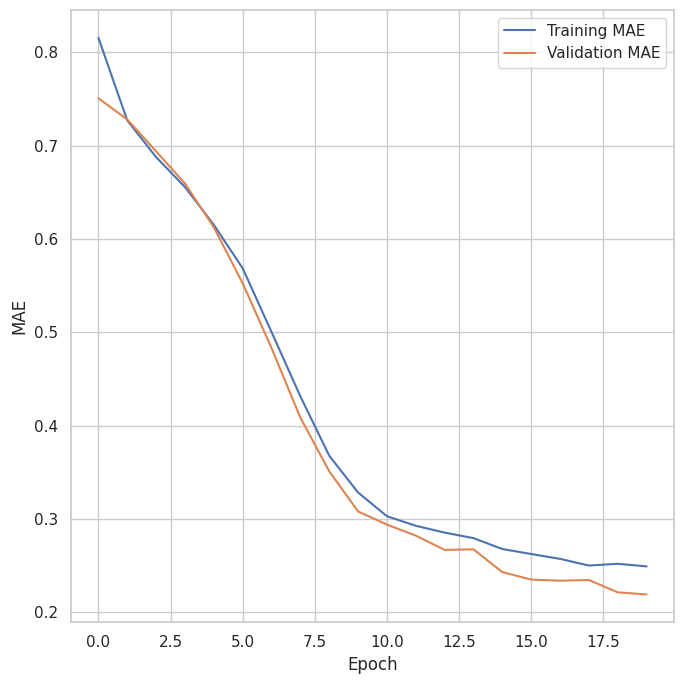

Final Training Loss (Meridians): 0.1300
Final Validation Loss (Meridians): 0.1167
Final Training MAE (Meridians): 0.2493
Final Validation MAE (Meridians): 0.2192


In [282]:
# Check if histories exist for Meridians dataset
if 'history_meridians' in locals():
    # Visualization of training history for Meridians dataset
    # Loss curve for Meridians
    plt.figure(figsize=(7, 7))
    plt.plot(history_meridians.history['loss'], label='Training Loss')
    plt.plot(history_meridians.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.title('Meridians Loss Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, 'CONV_meridians_loss.png'), dpi=300)  # Save the loss curve
    plt.show()

    # MAE curve for Meridians
    plt.figure(figsize=(7, 7))
    plt.plot(history_meridians.history['mae'], label='Training MAE')
    plt.plot(history_meridians.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    # plt.title('Meridians MAE Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, 'CONV_meridians_mae.png'), dpi=300)  # Save the MAE curve
    plt.show()

    # Display final values for Meridians
    print(f"Final Training Loss (Meridians): {history_meridians.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss (Meridians): {history_meridians.history['val_loss'][-1]:.4f}")
    print(f"Final Training MAE (Meridians): {history_meridians.history['mae'][-1]:.4f}")
    print(f"Final Validation MAE (Meridians): {history_meridians.history['val_mae'][-1]:.4f}")
else:
    print("Meridians training history not found. Please train the model in 'Train,Save Model' box of Meridians to visualize metrics.")

####Scatter Plot per Modes

In [283]:
# Number of modes based on the size of the first dimension of the SPL matrix
n_modes = 40  # e.g., 40 modes
idx = 0
idxMer = 0

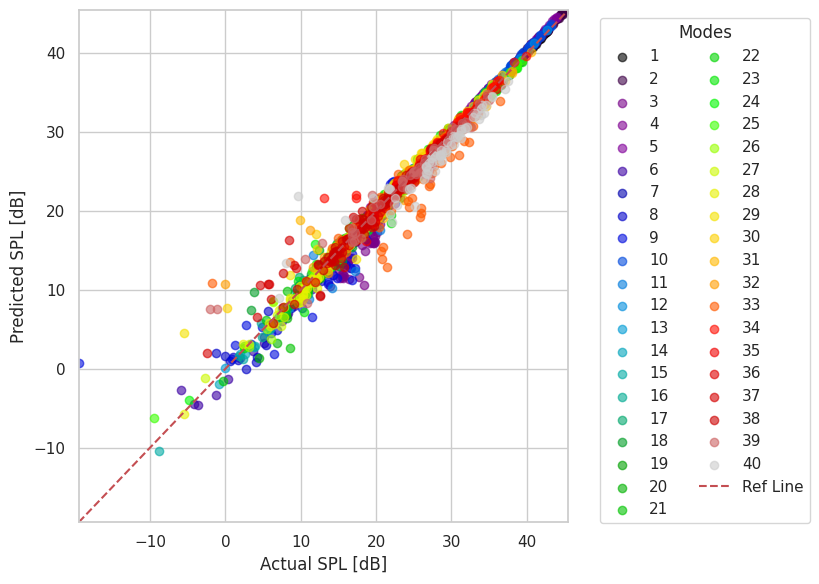

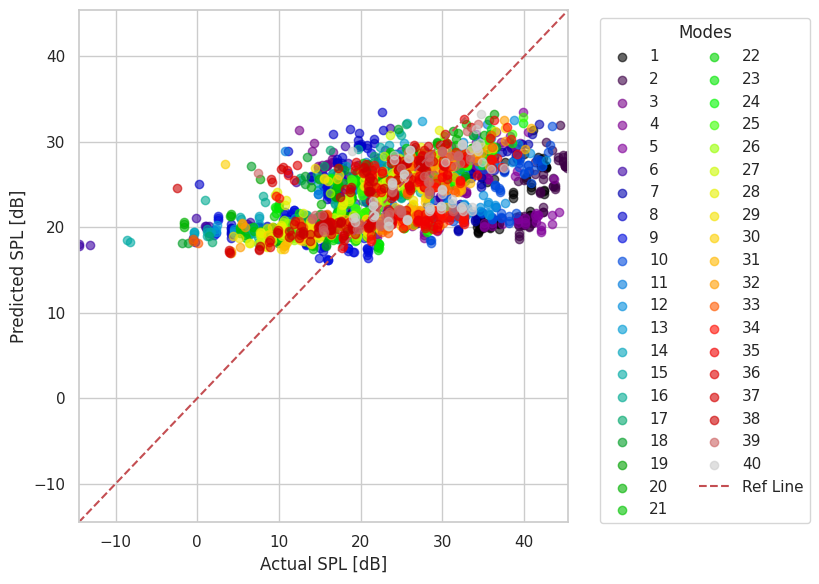

In [284]:
# Extract the actual values of the first simulation for the Fibonacci dataset
fibonacci_real = fibonacci_test[idx, :, :]  # Shape: (1, 40, 60)

# Flatten the predictions and the actual values for comparison
fibonacci_real_flat = fibonacci_real.flatten()  # Flatten for comparison
predictions_flat_fibonacci = predictions_Fib_descaled[idx, :, :].flatten()  # Shape: (40, 60)

# Create a color array for each mode
colors = cm.get_cmap('nipy_spectral', n_modes)

# Create scatter plot for Fibonacci
plt.figure(figsize=(10, 6))

# Iterate over the modes and create a scatter plot for each mode
for mode in range(n_modes):
    # Index range for each mode
    start_idx = mode * 60  # For example, 60 SPL points per mode
    end_idx = (mode + 1) * 60

    # Scatter plot of actual and predicted values for each mode
    plt.scatter(fibonacci_real_flat[start_idx:end_idx],
                predictions_flat_fibonacci[start_idx:end_idx],
                alpha=0.6, color=colors(mode),
                label=f'{mode + 1}')

# Reference line y=x
plt.plot([fibonacci_real_flat.min(), fibonacci_real_flat.max()],
         [fibonacci_real_flat.min(), fibonacci_real_flat.max()],
         'r--', label='Ref Line')

# Add title and labels
# plt.title('Comparison of Actual Values and Predictions Grouped by Mode (Fibonacci)')
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Predicted SPL [dB]')
plt.xlim(fibonacci_real_flat.min(), fibonacci_real_flat.max())
plt.ylim(fibonacci_real_flat.min(), fibonacci_real_flat.max())
plt.grid(True)

# Add legend outside the plot
plt.legend(title="Modes", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 'ncol=2' creates 2 columns for the legend

# Improve spacing and overall appearance
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space on the right for the legend


# Save the plot
plt.savefig(os.path.join(plot_directory,'CONV_Fib_scatterPlot.png'), bbox_inches='tight')

# Show the plot
plt.show()

# Extract the actual values of the first simulation for the Meridians dataset
meridians_real = meridians_test[idxMer, :, :]  # Shape: (1, 40, 60)

# Flatten the predictions and the actual values for comparison
meridians_real_flat = meridians_real.flatten()  # Flatten for comparison
predictions_flat_meridians = predictions_Mer_descaled[idxMer, :, :].flatten()  # Shape: (40, 60)

# Create a color array for each mode
colors = cm.get_cmap('nipy_spectral', n_modes)

# Create scatter plot for Meridians
plt.figure(figsize=(10, 6))

# Iterate over the modes and create a scatter plot for each mode
for mode in range(n_modes):
    # Index range for each mode
    start_idx = mode * 60  # For example, 60 SPL points per mode
    end_idx = (mode + 1) * 60

    # Scatter plot of actual and predicted values for each mode
    plt.scatter(meridians_real_flat[start_idx:end_idx],
                predictions_flat_meridians[start_idx:end_idx],
                alpha=0.6, color=colors(mode),
                label=f'{mode + 1}')

# Reference line y=x
plt.plot([meridians_real_flat.min(), meridians_real_flat.max()],
         [meridians_real_flat.min(), meridians_real_flat.max()],
         'r--', label='Ref Line')

# Add title and labels
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Predicted SPL [dB]')
plt.xlim(meridians_real_flat.min(), meridians_real_flat.max())
plt.ylim(meridians_real_flat.min(), meridians_real_flat.max())
plt.grid(True)

# Add legend outside the plot
plt.legend(title="Modes", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 'ncol=2' creates 2 columns for the legend

# Improve spacing and overall appearance
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space on the right for the legend

# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Mer_scatterPlot.png'), bbox_inches='tight')

# Show the plot
plt.show()


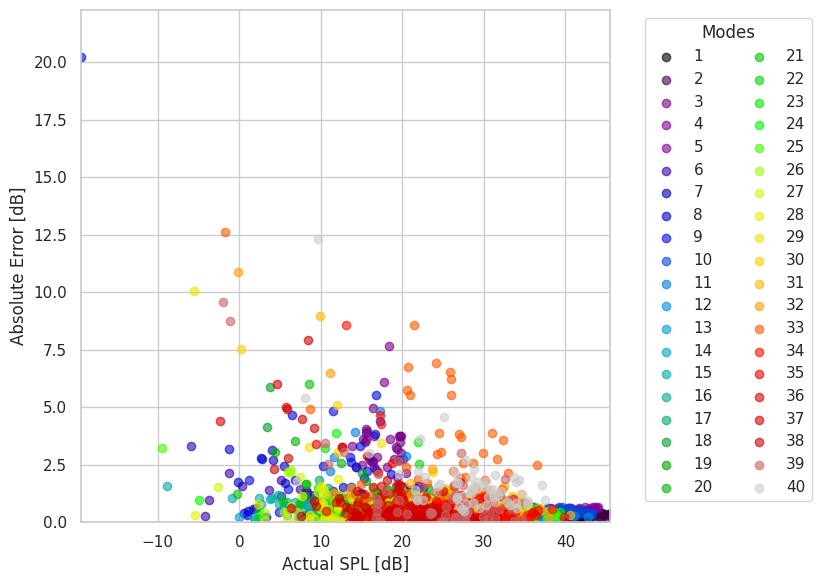

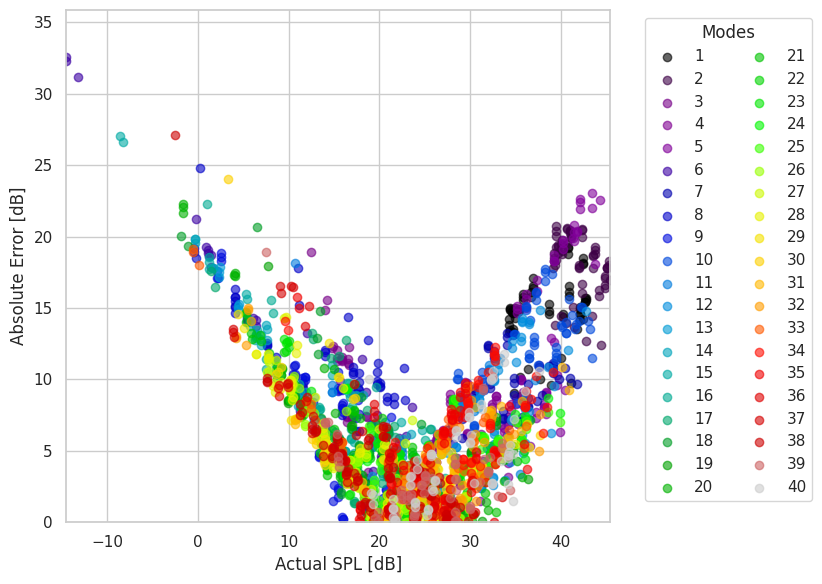

In [285]:
# Extract the actual Fibonacci values for the first simulation
fibonacci_real = fibonacci_test[idx, :, :]  # Shape: (1, 40, 60)

# Flatten the actual Fibonacci values and predictions for comparison
fibonacci_real_flat = fibonacci_real.flatten()  # Flatten for comparison
predictions_flat_fibonacci = predictions_Fib_descaled[idx, :, :].flatten()  # Shape: (40, 60)

# Calculate the absolute errors
errors_fibonacci = np.abs(predictions_flat_fibonacci - fibonacci_real_flat)  # Absolute error

# Create a color map for each mode
colors = cm.get_cmap('nipy_spectral', n_modes)

# Create the scatter plot for Fibonacci
plt.figure(figsize=(10, 6))

# Iterate over modes and create a scatter plot for each mode
for mode in range(n_modes):
    # Index range for each mode
    start_idx = mode * 60  # For example, 60 SPL points per mode
    end_idx = (mode + 1) * 60

    # Scatter plot of actual Fibonacci values and corresponding errors for each mode
    plt.scatter(fibonacci_real_flat[start_idx:end_idx],
                errors_fibonacci[start_idx:end_idx],
                alpha=0.6, color=colors(mode),
                label=f'{mode + 1}')

# Add title and labels
# plt.title('Error vs. Magnitude for Each Mode (Fibonacci)')
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Absolute Error [dB]')
plt.xlim(fibonacci_real_flat.min(), fibonacci_real_flat.max())
plt.ylim(0, np.max(errors_fibonacci) * 1.1)  # Set limits for better visualization
plt.grid(True)

# Add legend outside the plot
plt.legend(title="Modes", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 'ncol=2' creates 2 columns for the legend

# Improve spacing and overall appearance
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space to the right for the legend


# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Fib_scatterPlot_errors.png'), bbox_inches='tight')

# Show the plot
plt.show()


# Extract the actual Meridians values for the first simulation
meridians_real = meridians_test[idx, :, :]  # Shape: (1, 40, 60)

# Flatten the actual Meridians values and predictions for comparison
meridians_real_flat = meridians_real.flatten()  # Flatten for comparison
predictions_flat_meridians = predictions_Mer_descaled[idx, :, :].flatten()  # Shape: (40, 60)

# Calculate the absolute errors
errors_meridians = np.abs(predictions_flat_meridians - meridians_real_flat)  # Absolute error

# Create a color map for each mode
colors = cm.get_cmap('nipy_spectral', n_modes)

# Create the scatter plot for Meridians
plt.figure(figsize=(10, 6))

# Iterate over modes and create a scatter plot for each mode
for mode in range(n_modes):
    # Index range for each mode
    start_idx = mode * 60  # For example, 60 SPL points per mode
    end_idx = (mode + 1) * 60

    # Scatter plot of actual Meridians values and corresponding errors for each mode
    plt.scatter(meridians_real_flat[start_idx:end_idx],
                errors_meridians[start_idx:end_idx],
                alpha=0.6, color=colors(mode),
                label=f'{mode + 1}')

# Add title and labels
# plt.title('Error vs. Magnitude for Each Mode (Meridians)')
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Absolute Error [dB]')
plt.xlim(meridians_real_flat.min(), meridians_real_flat.max())
plt.ylim(0, np.max(errors_meridians) * 1.1)  # Set limits for better visualization
plt.grid(True)

# Add legend outside the plot
plt.legend(title="Modes", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 'ncol=2' creates 2 columns for the legend

# Improve spacing and overall appearance
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Extra space to the right for the legend


# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Mer_scatterPlot_errors.png'), bbox_inches='tight')

# Show the plot
plt.show()


Mode with Maximum Average Error (Fibonacci): 33 
Average Error: 2.5452 dB

Maximum Error for Mode 33 (Fibonacci): 12.6039 dB
Index of Maximum Error for Mode 33 (Fibonacci): 37

Minimum Error for Mode 33 (Fibonacci): 0.0297 dB
Index of Minimum Error for Mode 33 (Fibonacci): 42



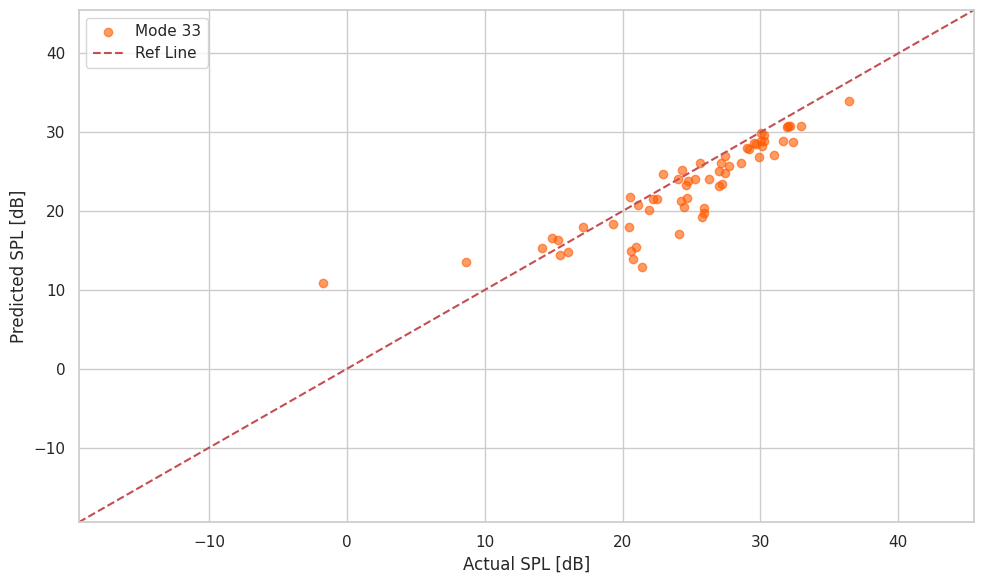

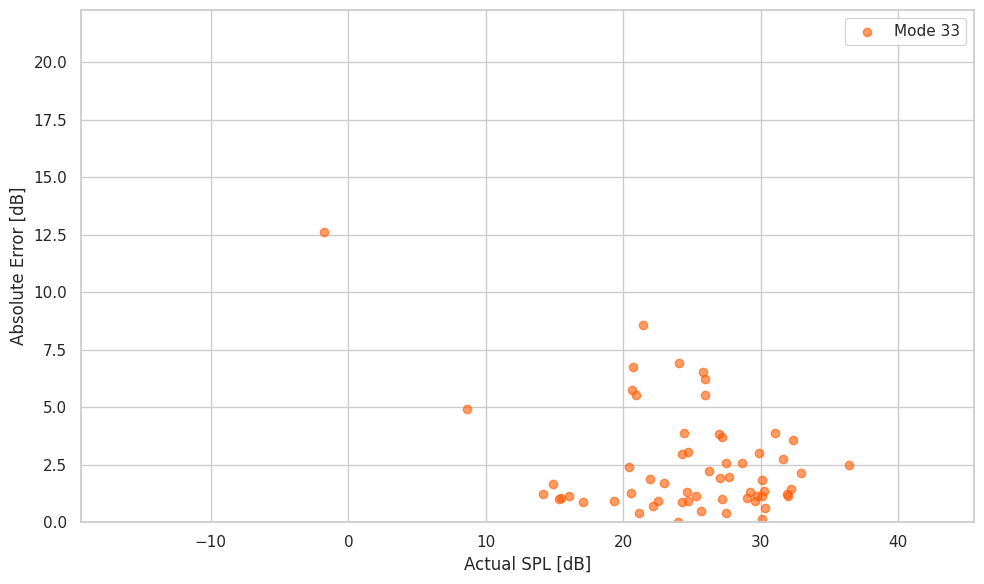

In [286]:
# Calculate the absolute errors for Fibonacci
errors_fibonacci = np.abs(predictions_flat_fibonacci - fibonacci_real_flat)  # Absolute error calculation

# Calculate average errors for each mode to find the mode with the maximum error
average_errors_fibonacci = np.array([np.mean(errors_fibonacci[mode * 60:(mode + 1) * 60]) for mode in range(n_modes)])  # Mean error per mode
max_error_mode_fibonacci = np.argmax(average_errors_fibonacci)  # Find the index of the mode with maximum average error
max_average_error_fibonacci = average_errors_fibonacci[max_error_mode_fibonacci]  # Get the maximum average error value

# Print the mode with the maximum average error and its value for Fibonacci
print(f'Mode with Maximum Average Error (Fibonacci): {max_error_mode_fibonacci + 1} \nAverage Error: {max_average_error_fibonacci:.4f} dB')

# Calculate the absolute errors for the mode with the maximum error in Fibonacci
errors_for_max_mode_fibonacci = errors_fibonacci[max_error_mode_fibonacci * 60:(max_error_mode_fibonacci + 1) * 60]  # Slice errors for the specific mode

# Find the maximum and minimum error for that mode
max_error_value_fibonacci = np.max(errors_for_max_mode_fibonacci)  # Maximum error calculation
max_error_index_fibonacci = np.argmax(errors_for_max_mode_fibonacci)  # Index of maximum error
min_error_value_fibonacci = np.min(errors_for_max_mode_fibonacci)  # Minimum error calculation
min_error_index_fibonacci = np.argmin(errors_for_max_mode_fibonacci)  # Index of minimum error

# Print the maximum and minimum absolute error and their corresponding indices for Fibonacci
print(f'\nMaximum Error for Mode {max_error_mode_fibonacci + 1} (Fibonacci): {max_error_value_fibonacci:.4f} dB')
print(f'Index of Maximum Error for Mode {max_error_mode_fibonacci + 1} (Fibonacci): {max_error_index_fibonacci + 1}')  # Adjusting for 1-based indexing
print(f'\nMinimum Error for Mode {max_error_mode_fibonacci + 1} (Fibonacci): {min_error_value_fibonacci:.4f} dB')
print(f'Index of Minimum Error for Mode {max_error_mode_fibonacci + 1} (Fibonacci): {min_error_index_fibonacci + 1}\n')  # Adjusting for 1-based indexing

# Create a color map for each mode
colors = cm.get_cmap('nipy_spectral', n_modes)

# Plot 1: Compare actual values vs predictions for Fibonacci
plt.figure(figsize=(10, 6))
# Index range for the mode with the maximum error in Fibonacci
start_idx_fibonacci = max_error_mode_fibonacci * 60
end_idx_fibonacci = (max_error_mode_fibonacci + 1) * 60

# Scatter plot of actual Fibonacci values and corresponding predictions for the mode with the maximum error
plt.scatter(fibonacci_real_flat[start_idx_fibonacci:end_idx_fibonacci],
            predictions_flat_fibonacci[start_idx_fibonacci:end_idx_fibonacci],
            alpha=0.6, color=colors(max_error_mode_fibonacci),
            label=f'Mode {max_error_mode_fibonacci + 1}')  # Label for the maximum error mode

# Line y=x for reference
plt.plot([fibonacci_real_flat.min(), fibonacci_real_flat.max()],
         [fibonacci_real_flat.min(), fibonacci_real_flat.max()],
         'r--', label='Ref Line')  # Reference line for ideal predictions

# Add title and labels for the Fibonacci plot
# plt.title(f'Actual vs. Predictions for Mode {max_error_mode_fibonacci + 1} (Fibonacci)')
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Predicted SPL [dB]')
plt.xlim(fibonacci_real_flat.min(), fibonacci_real_flat.max())
plt.ylim(fibonacci_real_flat.min(), fibonacci_real_flat.max())
plt.grid(True)
plt.legend(loc='upper left')  # Legend position
plt.tight_layout()
# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Fib_scatterPlot_maxErrorMode.png'), bbox_inches='tight')
plt.show()

# Plot 2: Actual values vs absolute errors for Fibonacci
plt.figure(figsize=(10, 6))
# Scatter plot for absolute errors in Fibonacci
plt.scatter(fibonacci_real_flat[start_idx_fibonacci:end_idx_fibonacci],
            errors_fibonacci[start_idx_fibonacci:end_idx_fibonacci],
            alpha=0.6, color=colors(max_error_mode_fibonacci))

# Add title and labels for the Fibonacci error plot
# plt.title(f'Error vs. Actual Values for Mode {max_error_mode_fibonacci + 1} (Fibonacci)')
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Absolute Error [dB]')
plt.xlim(fibonacci_real_flat.min(), fibonacci_real_flat.max())
plt.ylim(0, np.max(errors_fibonacci) * 1.1)  # Set limits for better visualization
plt.grid(True)

# Update legend to only show the mode number
plt.legend([f'Mode {max_error_mode_fibonacci + 1}'])  # Show only the mode in the legend
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Fib_errorPlot_maxErrorMode.png'), bbox_inches='tight')  # Updated file name for error plot
plt.show()


Mode with Maximum Average Error (Meridians): 2 
Average Error: 18.0325 dB

Maximum Error for Mode 2 (Meridians): 20.7295 dB
Index of Maximum Error for Mode 2 (Meridians): 54

Minimum Error for Mode 2 (Meridians): 12.4302 dB
Index of Minimum Error for Mode 2 (Meridians): 38



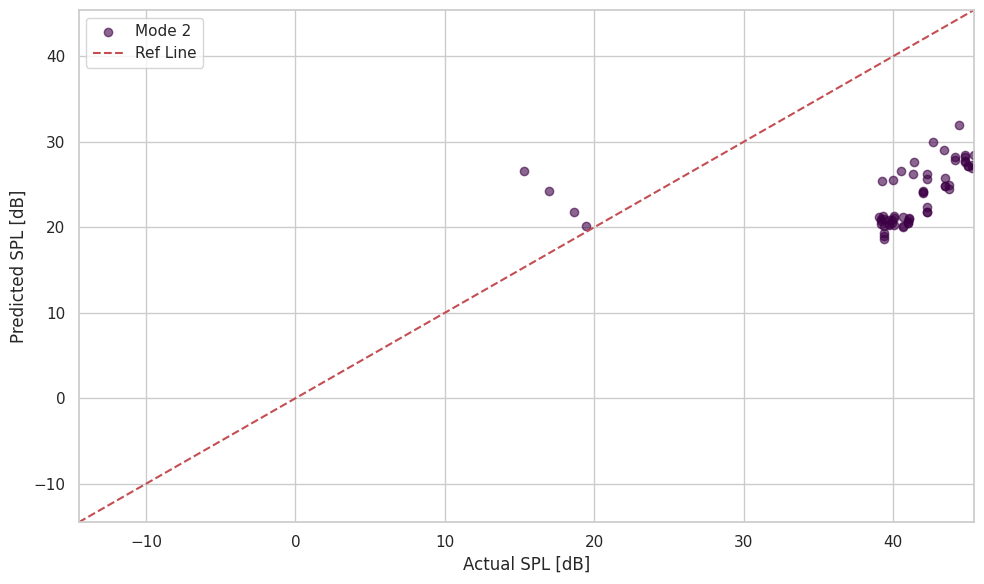

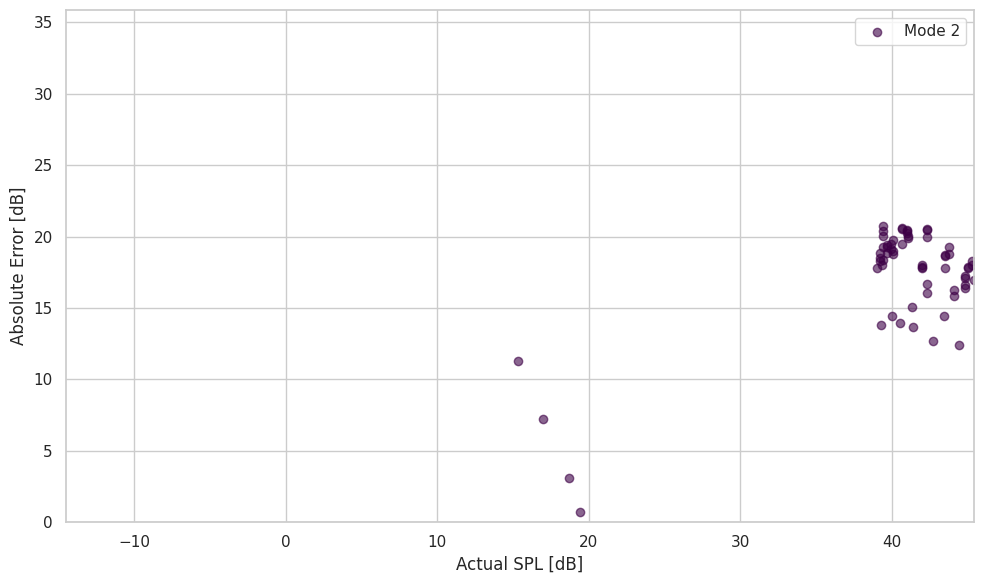

In [287]:
# Calculate the absolute errors for Meridians
errors_meridians = np.abs(predictions_flat_meridians - meridians_real_flat)  # Absolute error calculation

# Calculate average errors for each mode to find the mode with the maximum error
average_errors_meridians = np.array([np.mean(errors_meridians[mode * 60:(mode + 1) * 60]) for mode in range(n_modes)])  # Mean error per mode
max_error_mode_meridians = np.argmax(average_errors_meridians)  # Find the index of the mode with maximum average error
max_average_error_meridians = average_errors_meridians[max_error_mode_meridians]  # Get the maximum average error value

# Print the mode with the maximum average error and its value for Meridians
print(f'Mode with Maximum Average Error (Meridians): {max_error_mode_meridians + 1} \nAverage Error: {max_average_error_meridians:.4f} dB')

# Calculate the absolute errors for the mode with the maximum error in Meridians
errors_for_max_mode_meridians = errors_meridians[max_error_mode_meridians * 60:(max_error_mode_meridians + 1) * 60]  # Slice errors for the specific mode

# Find the maximum and minimum error for that mode
max_error_value_meridians = np.max(errors_for_max_mode_meridians)  # Maximum error calculation
max_error_index_meridians = np.argmax(errors_for_max_mode_meridians)  # Index of maximum error
min_error_value_meridians = np.min(errors_for_max_mode_meridians)  # Minimum error calculation
min_error_index_meridians = np.argmin(errors_for_max_mode_meridians)  # Index of minimum error

# Print the maximum and minimum absolute error and their corresponding indices for Meridians
print(f'\nMaximum Error for Mode {max_error_mode_meridians + 1} (Meridians): {max_error_value_meridians:.4f} dB')
print(f'Index of Maximum Error for Mode {max_error_mode_meridians + 1} (Meridians): {max_error_index_meridians + 1}')  # Adjusting for 1-based indexing
print(f'\nMinimum Error for Mode {max_error_mode_meridians + 1} (Meridians): {min_error_value_meridians:.4f} dB')
print(f'Index of Minimum Error for Mode {max_error_mode_meridians + 1} (Meridians): {min_error_index_meridians + 1}\n')  # Adjusting for 1-based indexing

# Create a color map for each mode (same as Fibonacci)
colors = cm.get_cmap('nipy_spectral', n_modes)

# Plot 3: Compare actual values vs predictions for Meridians
plt.figure(figsize=(10, 6))
# Index range for the mode with the maximum error in Meridians
start_idx_meridians = max_error_mode_meridians * 62
end_idx_meridians = (max_error_mode_meridians + 1) * 62

# Scatter plot of actual Meridians values and corresponding predictions for the mode with the maximum error
plt.scatter(meridians_real_flat[start_idx_meridians:end_idx_meridians],
            predictions_flat_meridians[start_idx_meridians:end_idx_meridians],
            alpha=0.6, color=colors(max_error_mode_meridians),
            label=f'Mode {max_error_mode_meridians + 1}')  # Label for the maximum error mode

# Line y=x for reference
plt.plot([meridians_real_flat.min(), meridians_real_flat.max()],
         [meridians_real_flat.min(), meridians_real_flat.max()],
         'r--', label='Ref Line')  # Reference line for ideal predictions

# Add title and labels for the Meridians plot
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Predicted SPL [dB]')
plt.xlim(meridians_real_flat.min(), meridians_real_flat.max())
plt.ylim(meridians_real_flat.min(), meridians_real_flat.max())
plt.grid(True)
plt.legend(loc='upper left')  # Legend position
plt.tight_layout()
# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Mer_scatterPlot_maxErrorMode.png'), bbox_inches='tight')
plt.show()

# Plot 4: Actual values vs absolute errors for Meridians
plt.figure(figsize=(10, 6))
# Scatter plot for absolute errors in Meridians
plt.scatter(meridians_real_flat[start_idx_meridians:end_idx_meridians],
            errors_meridians[start_idx_meridians:end_idx_meridians],
            alpha=0.6, color=colors(max_error_mode_meridians))

# Add title and labels for the Meridians error plot
plt.xlabel('Actual SPL [dB]')
plt.ylabel('Absolute Error [dB]')
plt.xlim(meridians_real_flat.min(), meridians_real_flat.max())
plt.ylim(0, np.max(errors_meridians) * 1.1)  # Set limits for better visualization
plt.grid(True)

# Update legend to only show the mode number
plt.legend([f'Mode {max_error_mode_meridians + 1}'])  # Show only the mode in the legend
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Mer_errorPlot_maxErrorMode.png'), bbox_inches='tight')  # Updated file name for error plot
plt.show()


####Errors

Mode with maximum error: 39, Error: 1.89 dB
Mode with minimum error: 1, Error: 0.28 dB


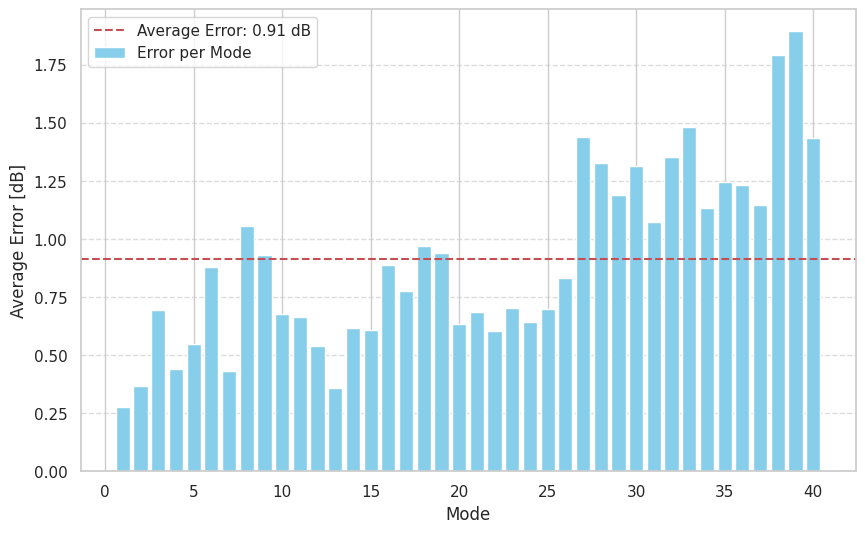

In [288]:
# Assume `spl_original` is the real SPL matrix with shape (n_sim, 40, 60)
# Assume `predictions_Fib_descaled` is the predicted matrix with shape (n_sim, 40, 60)

# List to store the average percentage errors for each simulation
average_errors_per_sim = []
fibonacci_real = fibonacci_test  # Shape: (n_sim, 40, 60)

# Loop through all simulations
for i in range(predictions_Fib_descaled.shape[0]):
    # Extract the real SPL matrix and the predicted one for the current simulation
    spl_real = fibonacci_real[i, :, :]  # Real matrix (40, 60) for simulation i
    spl_pred = predictions_Fib_descaled[i, :, :]  # Predicted matrix (40, 60) for simulation i

    # Calculate the absolute error for each mode
    errors = np.abs(spl_pred - spl_real)

    # Calculate the symmetric percentage error for each mode
    dB_error = errors

    # Calculate the mean errors for each mode (row)
    mode_errors = np.mean(dB_error, axis=1)  # Mean for each mode (40 modes)

    # Append the mean error for this simulation to the list
    average_errors_per_sim.append(mode_errors)

# Ensure average_errors_per_sim is a NumPy array
average_errors_per_sim = np.array(average_errors_per_sim)

# Calculate the mean errors across all simulations
overall_average_error = np.mean(average_errors_per_sim, axis=0)  # Average of errors across all simulations

# Calculate the maximum and minimum average errors for each mode
max_mode_error = np.max(overall_average_error)  # Maximum error across modes
min_mode_error = np.min(overall_average_error)  # Minimum error across modes

# Find the indices of the modes with the maximum and minimum errors
max_mode_idx = np.argmax(overall_average_error)  # Index of mode with max error
min_mode_idx = np.argmin(overall_average_error)  # Index of mode with min error

# Print the maximum and minimum errors and their corresponding modes
print(f"Mode with maximum error: {max_mode_idx + 1}, Error: {max_mode_error:.2f} dB")  # +1 for 1-based index
print(f"Mode with minimum error: {min_mode_idx + 1}, Error: {min_mode_error:.2f} dB")  # +1 for 1-based index

# Representation of results with a bar plot
plt.figure(figsize=(10, 6))

# Plot the values of overall_average_error on a bar graph
modes = range(1, len(overall_average_error) + 1)  # Generate a list of modes for the x-axis
plt.bar(modes, overall_average_error, color='skyblue', label="Error per Mode")

# Calculate the overall average error
global_average_error = np.mean(overall_average_error)

# Add a line for the average value
plt.axhline(y=global_average_error, color='r', linestyle='--', label=f"Average Error: {global_average_error:.2f} dB")

# Add labels
plt.xlabel('Mode')
plt.ylabel('Average Error [dB]')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the legend
plt.legend()


# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Fib_errorsPerMode.png'), bbox_inches='tight')
# Show the plot
plt.show()


Mode with maximum error (Meridians): 2, Error: 17.75 dB
Mode with minimum error (Meridians): 25, Error: 3.33 dB


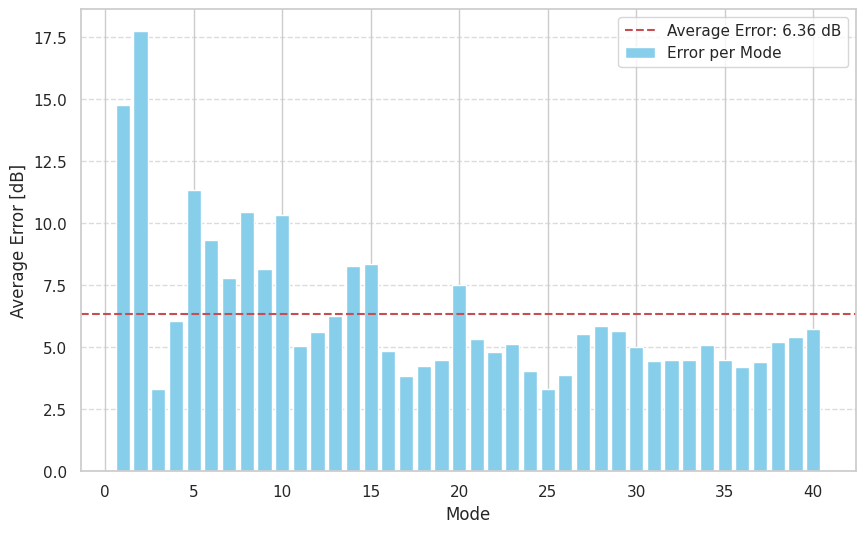

In [289]:
# Assume `meridians_real` is the real SPL matrix for the Meridians with shape (n_sim, 40, 60)
# Assume `predictions_Mer_descaled` is the predicted matrix for the Meridians with shape (n_sim, 40, 60)

# List to store the average percentage errors for each simulation
average_errors_per_sim_meridians = []
meridians_real = meridians_test  # Shape: (n_sim, 40, 60)

# Loop through all simulations for Meridians
for i in range(predictions_Mer_descaled.shape[0]):
    # Extract the real SPL matrix and the predicted one for the current simulation
    spl_real = meridians_real[i, :, :]  # Real matrix (40, 60) for simulation i
    spl_pred = predictions_Mer_descaled[i, :, :]  # Predicted matrix (40, 60) for simulation i

    # Calculate the absolute error for each mode
    errors = np.abs(spl_pred - spl_real)

    # Calculate the symmetric percentage error for each mode
    dB_error = errors

    # Calculate the mean errors for each mode (row)
    mode_errors = np.mean(dB_error, axis=1)  # Mean for each mode (40 modes)

    # Append the mean error for this simulation to the list
    average_errors_per_sim_meridians.append(mode_errors)

# Ensure average_errors_per_sim_meridians is a NumPy array
average_errors_per_sim_meridians = np.array(average_errors_per_sim_meridians)

# Calculate the mean errors across all simulations for Meridians
overall_average_error_meridians = np.mean(average_errors_per_sim_meridians, axis=0)  # Average of errors across all simulations

# Calculate the maximum and minimum average errors for each mode
max_mode_error_meridians = np.max(overall_average_error_meridians)  # Maximum error across modes
min_mode_error_meridians = np.min(overall_average_error_meridians)  # Minimum error across modes

# Find the indices of the modes with the maximum and minimum errors
max_mode_idx_meridians = np.argmax(overall_average_error_meridians)  # Index of mode with max error
min_mode_idx_meridians = np.argmin(overall_average_error_meridians)  # Index of mode with min error

# Print the maximum and minimum errors and their corresponding modes for Meridians
print(f"Mode with maximum error (Meridians): {max_mode_idx_meridians + 1}, Error: {max_mode_error_meridians:.2f} dB")  # +1 for 1-based index
print(f"Mode with minimum error (Meridians): {min_mode_idx_meridians + 1}, Error: {min_mode_error_meridians:.2f} dB")  # +1 for 1-based index

# Representation of results with a bar plot for Meridians
plt.figure(figsize=(10, 6))

# Plot the values of overall_average_error_meridians on a bar graph
modes = range(1, len(overall_average_error_meridians) + 1)  # Generate a list of modes for the x-axis
plt.bar(modes, overall_average_error_meridians, color='skyblue', label="Error per Mode")

# Calculate the overall average error for Meridians
global_average_error_meridians = np.mean(overall_average_error_meridians)

# Add a line for the average value
plt.axhline(y=global_average_error_meridians, color='r', linestyle='--', label=f"Average Error: {global_average_error_meridians:.2f} dB")

# Add labels
plt.xlabel('Mode')
plt.ylabel('Average Error [dB]')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the legend
plt.legend()


# Save the plot
plt.savefig(os.path.join(plot_directory, 'CONV_Mer_errorsPerMode.png'), bbox_inches='tight')
# Show the plot
plt.show()


####Matrixplots

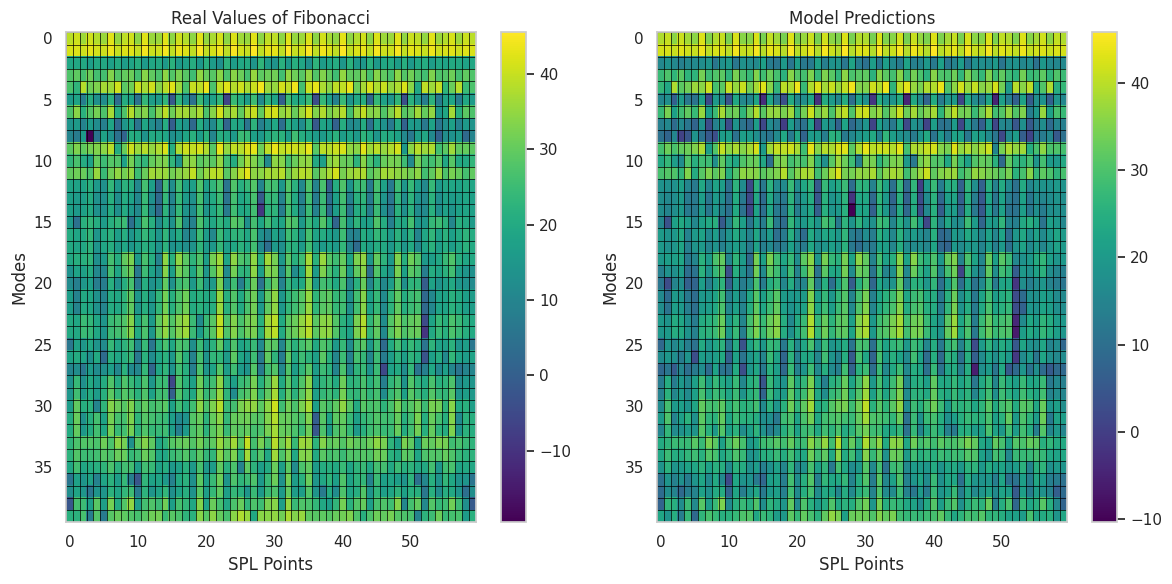

(50, 40, 60)
(50, 7, 60)
[16.629343 14.667489 19.337946 23.989296 24.412004 14.908662 19.113134
 19.219164 17.056438 13.377197 20.805298 13.785058 17.020529 26.466108
 24.862484 14.415841 23.570482 24.883642 26.589943 26.027893 22.622967
 16.638365 22.886908 17.229343 13.386195 17.063057 20.103113 21.114656
 29.26938  24.795538 29.664555 25.710287 20.304619 18.971245 30.494843
 15.866638 22.79028  29.330708 24.723278 20.093245 19.906637 13.919454
 21.282385 20.713293 15.923405 13.911579 23.107218 19.066023 23.141438
 14.159546]
[13.377197 13.386195 13.785058 13.911579 13.919454 14.159546 14.415841
 14.667489 14.908662 15.866638 15.923405 16.629343 16.638365 17.020529
 17.056438 17.063057 17.229343 18.971245 19.066023 19.113134 19.219164
 19.337946 19.906637 20.093245 20.103113 20.304619 20.713293 20.805298
 21.114656 21.282385 22.622967 22.79028  22.886908 23.107218 23.141438
 23.570482 23.989296 24.412004 24.723278 24.795538 24.862484 24.883642
 25.710287 26.027893 26.466108 26.589943

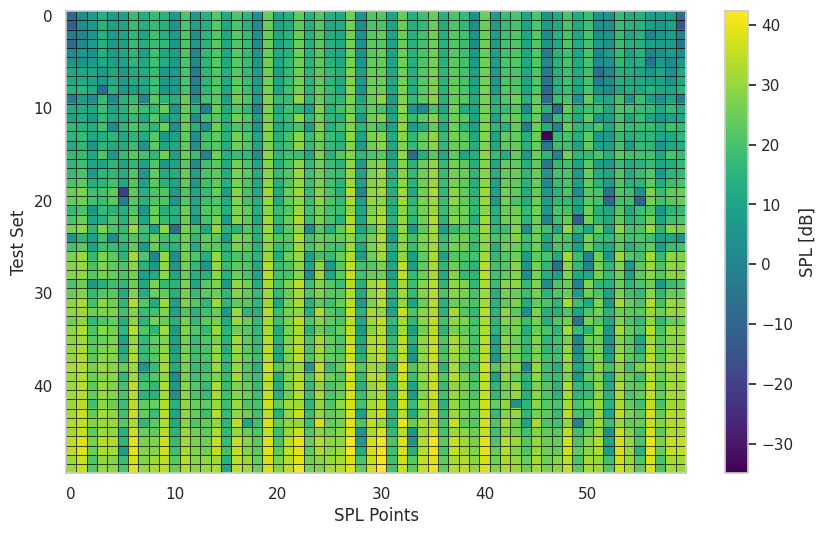

In [304]:

# Assume fibonacci_test is defined and contains SPL data with shape (n_sim, 40, 60)

# Extract the real values for the first simulation from the Fibonacci matrix
fibonacci_real = fibonacci_test[idx, :, :]  # Shape: (1, 40, 60)
fibonacci_real = fibonacci_real.reshape(40, 60)  # Restore shape

# Create a subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Matrix plot for the real values with linewidth
c1 = axes[0].imshow(fibonacci_real, aspect='auto', cmap='viridis', interpolation='none')
axes[0].set_title('Real Values of Fibonacci')
axes[0].set_xlabel('SPL Points')
axes[0].set_ylabel('Modes')
axes[0].grid(False)
plt.colorbar(c1, ax=axes[0])

# Add grid using lines between cells with linewidths
for i in range(fibonacci_real.shape[0] + 1):
    axes[0].axhline(i - 0.5, color='black', lw=0.5)
for j in range(fibonacci_real.shape[1] + 1):
    axes[0].axvline(j - 0.5, color='black', lw=0.5)

# Matrix plot for the predictions with linewidth
predictions_matrix = predictions_Fib_descaled[idx, :, :]  # Assume this variable is defined
c2 = axes[1].imshow(predictions_matrix, aspect='auto', cmap='viridis', interpolation='none')
axes[1].set_title('Model Predictions')
axes[1].set_xlabel('SPL Points')
axes[1].set_ylabel('Modes')
axes[1].grid(False)
plt.colorbar(c2, ax=axes[1])

# Add grid using lines between cells with linewidths
for i in range(predictions_matrix.shape[0] + 1):
    axes[1].axhline(i - 0.5, color='black', lw=0.5)
for j in range(predictions_matrix.shape[1] + 1):
    axes[1].axvline(j - 0.5, color='black', lw=0.5)

plt.tight_layout()
plt.show()

# Calculate the mean error for each mode
absolute_errors = np.abs(predictions_flat_fibonacci - fibonacci_real_flat)
average_mode_errors = np.mean(absolute_errors.reshape(-1, 60), axis=0)

# Print shape for confirmation
print(fibonacci_test.shape)
print(fibonacci_test[:, 0:7, :].shape)

# Assuming fibonacci_test[:, 0:7, :] contains data of shape (n_sim, 7, n_points)
# Perform slicing to get the required data
data_slice = []
for i in range(fibonacci_test.shape[0]):
    data_slice.append(fibonacci_test[i, 27, :])  # Extract the desired row
data_slice = np.array(data_slice)

# Calculate the mean for each row
mean_values = np.mean(data_slice, axis=1)
print(mean_values)

# Sort the rows based on the mean
sorted_mean = np.sort(mean_values)
print(sorted_mean)

# Find the sorted indices based on the mean
sorted_indices = np.argsort(mean_values)  # Get sorted indices based on the mean
print(sorted_indices)

# Create a sorted matrix based on the indices
matrix_data_sorted = data_slice[sorted_indices]

# Print shape for confirmation
print(matrix_data_sorted.shape)

# Create the matrix plot with sorted data
plt.figure(figsize=(10, 6))
plt.imshow(matrix_data_sorted, aspect='auto', cmap='viridis')

# Add a color bar to interpret values
plt.colorbar(label='SPL [dB]')
# plt.title('Matrix Plot of SPL Values Sorted by Mean')
plt.xlabel('SPL Points')
plt.ylabel('Test Set')
# Add grid lines using axhline and axvline for borders
for i in range(matrix_data_sorted.shape[0] + 1):
    plt.axhline(i - 0.5, color='black', lw=0.5)  # Add horizontal lines
for j in range(matrix_data_sorted.shape[1] + 1):
    plt.axvline(j - 0.5, color='black', lw=0.5)  # Add vertical lines
plt.grid(False)
# Show the plot
plt.show()


(50, 40, 60)
(50, 7, 60)
[16.629343 14.667489 19.337946 23.989296 24.412004 14.908662 19.113134
 19.219164 17.056438 13.377197 20.805298 13.785058 17.020529 26.466108
 24.862484 14.415841 23.570482 24.883642 26.589943 26.027893 22.622967
 16.638365 22.886908 17.229343 13.386195 17.063057 20.103113 21.114656
 29.26938  24.795538 29.664555 25.710287 20.304619 18.971245 30.494843
 15.866638 22.79028  29.330708 24.723278 20.093245 19.906637 13.919454
 21.282385 20.713293 15.923405 13.911579 23.107218 19.066023 23.141438
 14.159546]
[13.377197 13.386195 13.785058 13.911579 13.919454 14.159546 14.415841
 14.667489 14.908662 15.866638 15.923405 16.629343 16.638365 17.020529
 17.056438 17.063057 17.229343 18.971245 19.066023 19.113134 19.219164
 19.337946 19.906637 20.093245 20.103113 20.304619 20.713293 20.805298
 21.114656 21.282385 22.622967 22.79028  22.886908 23.107218 23.141438
 23.570482 23.989296 24.412004 24.723278 24.795538 24.862484 24.883642
 25.710287 26.027893 26.466108 26.589943

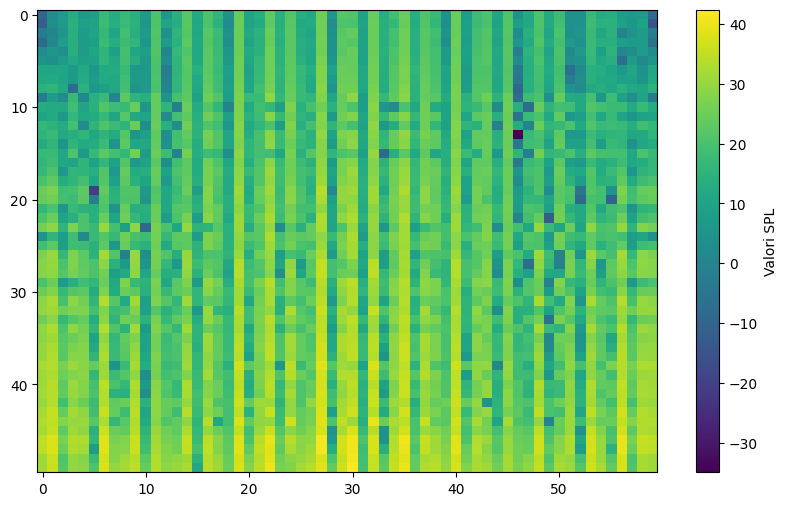

In [ ]:
# Estrai i valori reali della prima simulazione di Fibonacci
fibonacci_real = fibonacci_test[idx,:,:]  # Shape: (1, 40, 60)
# fibonacci_real = fibonacci_matrix[idx,:,:]  # Shape: (1, 40, 60) #prima sim assoluta
fibonacci_real = fibonacci_real.reshape(40, 60)  # Ripristina la forma


# # Predizioni desnormalizzate
# predictions_matrix = predictions_descaled[idx, :, :]  # Shape: (40, 60)

# # Crea un subplot
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Matrix plot per i valori reali con linewidth
# c1 = axes[0].imshow(fibonacci_real, aspect='auto', cmap='viridis', interpolation='none')
# axes[0].set_title('Valori Reali di Fibonacci')
# axes[0].set_xlabel('Punti SPL')
# axes[0].set_ylabel('Modes')
# plt.colorbar(c1, ax=axes[0])

# # Aggiungi griglia usando bordi tra le celle con linewidths
# for i in range(fibonacci_real.shape[0] + 1):
#     axes[0].axhline(i - 0.5, color='white', lw=0.5)
# for j in range(fibonacci_real.shape[1] + 1):
#     axes[0].axvline(j - 0.5, color='white', lw=0.5)

# # Matrix plot per le predizioni con linewidth
# c2 = axes[1].imshow(predictions_matrix, aspect='auto', cmap='viridis', interpolation='none')
# axes[1].set_title('Predizioni del Modello')
# axes[1].set_xlabel('Punti SPL')
# axes[1].set_ylabel('Modes')
# plt.colorbar(c2, ax=axes[1])

# # Aggiungi griglia usando bordi tra le celle con linewidths
# for i in range(predictions_matrix.shape[0] + 1):
#     axes[1].axhline(i - 0.5, color='white', lw=0.5)
# for j in range(predictions_matrix.shape[1] + 1):
#     axes[1].axvline(j - 0.5, color='white', lw=0.5)

# plt.tight_layout()
# plt.show()

# Calcola l'errore medio per ogni mode
# absolute_errors = np.abs(predictions_flat - fibonacci_real_flat)
# average_mode_errors = np.mean(absolute_errors.reshape(-1, 60), axis=0)

print(fibonacci_test.shape)
print(fibonacci_test[:, 0:7 ,:].shape)


import matplotlib.pyplot as plt

# Supponiamo che fibonacci_test[:, 0:7, :] contenga dati di shape (n_sim, 7, n_points)
# Eseguiamo lo slicing richiesto per ottenere i dati
# Estrai il dato da fibonacci_test (assicurati che questo sia definito precedentemente nel tuo codice)
data_slice = []
for i in range(fibonacci_test.shape[0]):
    data_slice.append(fibonacci_test[i, 27, :])  # Estrai la riga desiderata
data_slice = np.array(data_slice)

# Calcola la media per ogni riga
mean_values = np.mean(data_slice, axis=1)
print(mean_values)
# Ordina le righe in base alla media
sorted_mean = np.sort(mean_values)
print(sorted_mean)

# Trova gli indici ordinati in base alla media
sorted_indices = np.argsort(mean_values)  # Ottieni gli indici ordinati in base alla media
print(sorted_indices)
matrix_data_sorted = data_slice[sorted_indices]

# Stampa la shape per conferma
print(matrix_data_sorted.shape)

# Crea il matrixplot con i dati ordinati
plt.figure(figsize=(10, 6))
plt.imshow(matrix_data_sorted, aspect='auto', cmap='viridis')

# Aggiungi una barra dei colori per interpretare i valori
plt.colorbar(label='Valori SPL')

# Aggiungi le etichette per l'asse x e y, se necessario
# plt.xlabel('Punti SPL')
# plt.ylabel('Modalità ordinate per media')

# Mostra il grafico
# plt.title('MatrixPlot dei valori SPL ordinati per media')
plt.show()

# Aggiungi etichette e titolo
# plt.xlabel('Realisations')
# plt.ylabel('Punti SPL')
# plt.title('Matrixplot del Mode 8 per Tutte le Simulazioni')

# Mostra il grafico
plt.show()

# # Subplot 1: Predicted Values
# plt.subplot(3, 1, 1)
# plt.imshow(max_error_values.reshape(1, -1), aspect='auto', cmap='viridis', extent=[0, 60, 0, 1])
# plt.colorbar(label='Valori SPL Predetti')
# plt.title(f'Matrixplot Predicted Values')
# plt.xlabel('SPL Points')
# plt.ylabel(f'Mode {max_error_mode + 1}')
# plt.yticks([])  # Remove ticks on the y-axis since there is only one mode
# plt.grid(False)  # Disable grid

# print(absolute_errors.shape)
# print(average_mode_errors.shape)


# Trova l'indice della mode con l'errore medio più alto
# max_error_mode = np.argmax(average_mode_errors)
# max_error_values = predictions_flat[max_error_mode * 60:(max_error_mode + 1) * 60]


# errors_matrix = np.array(average_errors_per_sim)  # Trasforma la lista in una matrice

# # Crea un matrixplot con i pattern per ogni mode
# plt.figure(figsize=(10, 6))
# plt.imshow(errors_matrix, aspect='auto', cmap='viridis', extent=[0, errors_matrix.shape[1], 1, errors_matrix.shape[0]])

# # Aggiungi una barra dei colori per interpretare i valori
# plt.colorbar(label='Errore Medio [dB]')

# # Aggiungi etichette e titolo
# plt.xlabel('Punti SPL')
# plt.ylabel('Mode')
# plt.title('Matrixplot degli Errori Medi per ciascun Mode')

# # Mostra il grafico
# plt.show()


# # Create a single figure for the three matrix plots
# plt.figure(figsize=(12, 6))

# # Subplot 1: Predicted Values
# plt.subplot(3, 1, 1)
# plt.imshow(max_error_values.reshape(1, -1), aspect='auto', cmap='viridis', extent=[0, 60, 0, 1])
# plt.colorbar(label='Valori SPL Predetti')
# plt.title(f'Matrixplot Predicted Values')
# plt.xlabel('SPL Points')
# plt.ylabel(f'Mode {max_error_mode + 1}')
# plt.yticks([])  # Remove ticks on the y-axis since there is only one mode
# plt.grid(False)  # Disable grid

# # Subplot 2: Real Values
# plt.subplot(3, 1, 2)
# plt.imshow(fibonacci_real_flat[max_error_mode * 60:(max_error_mode + 1) * 60].reshape(1, -1),
#            aspect='auto', cmap='viridis', extent=[0, 60, 0, 1])
# plt.colorbar(label='Valori SPL Reali')
# plt.title(f'Matrixplot Real Values')
# plt.xlabel('SPL Points')
# plt.ylabel(f'Mode {max_error_mode + 1}')
# plt.yticks([])  # Remove ticks on the y-axis since there is only one mode
# plt.grid(False)  # Disable grid

# # Subplot 3: Error Values
# plt.subplot(3, 1, 3)
# errors_for_max_mode = absolute_errors[max_error_mode * 60:(max_error_mode + 1) * 60]

# plt.imshow(errors_for_max_mode.reshape(1, -1), aspect='auto', cmap='viridis', extent=[0, 60, 0, 1])
# plt.colorbar(label='Error [dB]')
# plt.title(f'Matrixplot Errors')
# plt.xlabel('SPL Points')
# plt.ylabel(f'Mode {max_error_mode + 1}')
# plt.yticks([])  # Remove ticks on the y-axis since there is only one mode
# plt.grid(False)  # Disable grid

# # Improve spacing and overall appearance
# plt.tight_layout()  # Improve spacing

# # Show the combined plots
# plt.show()

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression


# Genera dati di esempio (sostituisci con i tuoi dati)
# X_test = np.random.rand(50, 7)  # Input di esempio (50, 7)
# y_test = np.random.rand(50, 1)  # Output di esempio (50, 1)

# Convert y_test to an array of floats
y_test = y_test.astype(np.float64)

# Add a column of bias (intercept), i.e., a column of 1s to X
X_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]
X_bias = X_bias.astype(np.float64)

# Calculate the coefficients of linear regression using linear algebra
W = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y_test

# Mostra i coefficienti
print("Coefficiente di regressione:", W[1:].flatten())  # Coefficienti per le variabili
print("Intercetta:", W[0])  # Intercetta

# Previsione manuale
y_pred = X_bias @ W


# Crea e addestra il regressore lineare
# model = LinearRegression()
# model.fit(X_test, y_test)

# Previsione con i dati di test
# y_pred = model.predict(X_test)

# Stampa i coefficienti e l'intercetta
# print("Coefficiente di regressione:", model.coef_)
# print("Intercetta:", model.intercept_)

# Mostra alcune delle previsioni
print("Previsioni su dati di test:", y_pred[:5])
